# Analysing datasets
In this notebook I'm going to collect and analyse all the datasets used so far.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1)
sns.set_style('white')

In [ ]:
import collections
import nltk
import re
nltk.download('stopwords')
en_stops = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3', cache_discovery=False)

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
def upload_from_drive(link, name):
  id = link.split('file/d/')[1].split('/view?usp=sharing')[0]
  downloaded = drive.CreateFile({'id': id}) 
  downloaded.GetContentFile(name) 

In [ ]:
def write_word(word, number, dataset_name):
  with open('frequent_words_' + dataset_name + '.txt', 'a') as f:
    for i in range(0, int(number)):
      f.write(word + ' ')

def collect_most_common_words(words, counts, dataset_name):
  for i in range(0, len(words)):
    write_word(words[i], counts[i], dataset_name)

## Newsworthiness detector

### Opinion dataset

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1O2UDUi025Z827vNgZI9q5Z3RYAyP-OZ5/view?usp=sharing', 'opinions0.csv')
upload_from_drive('https://drive.google.com/file/d/1ktJhb2OxmEYuc09XJR4bz8m5A0lKmpGT/view?usp=sharing', 'opinions1.csv')
upload_from_drive('https://drive.google.com/file/d/1EEnPThfkuHaYlqc7aQ-3OkZ2t9UVbS0T/view?usp=sharing', 'opinions2.csv')
upload_from_drive('https://drive.google.com/file/d/12yyNWB7EXKzBv6ooAmIpLFi360Cp777g/view?usp=sharing', 'opinions3.csv')
upload_from_drive('https://drive.google.com/file/d/1TcTMdUZ8h5rR1IH2aZNWn3d_MWXBOpLA/view?usp=sharing', 'opinions4.csv')

In [ ]:
df_opinions = pd.DataFrame()
for i in range(0,5):
  df_opinions = pd.concat([df_opinions, pd.read_csv('opinions' + str(i) + '.csv')])

df_opinions = df_opinions.drop(columns=['publisher', 'url'], axis=1)
df_opinions['text'] = df_opinions['text'].astype(str)
df_opinions = df_opinions.drop_duplicates()
df_opinions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15816 entries, 0 to 4713
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15816 non-null  object
dtypes: object(1)
memory usage: 247.1+ KB


In [ ]:
df_opinions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15816 entries, 0 to 4713
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15816 non-null  object
dtypes: object(1)
memory usage: 247.1+ KB


In [ ]:
df_opinions['length'] = df_opinions['text'].astype(str).apply(len)
df_opinions['wordcount'] = df_opinions['text'].astype(str).apply(lambda row: len(row.split(' ')))

In [ ]:
df_opinions['wordcount'].describe()

count    15816.000000
mean       459.712064
std        544.531536
min          1.000000
25%        203.000000
50%        336.000000
75%        535.000000
max      14600.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Opinion pieces length (less than 5000 characters)')

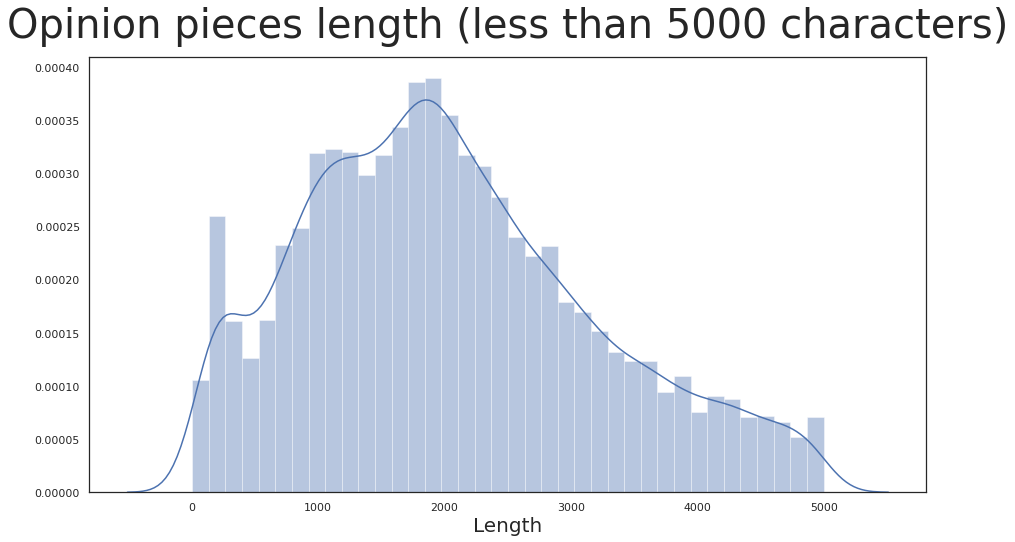

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_opinions[(df_opinions['length'] < 5000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Opinion pieces length (less than 5000 characters)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Opinion pieces wordcount (less than 2000 words)')

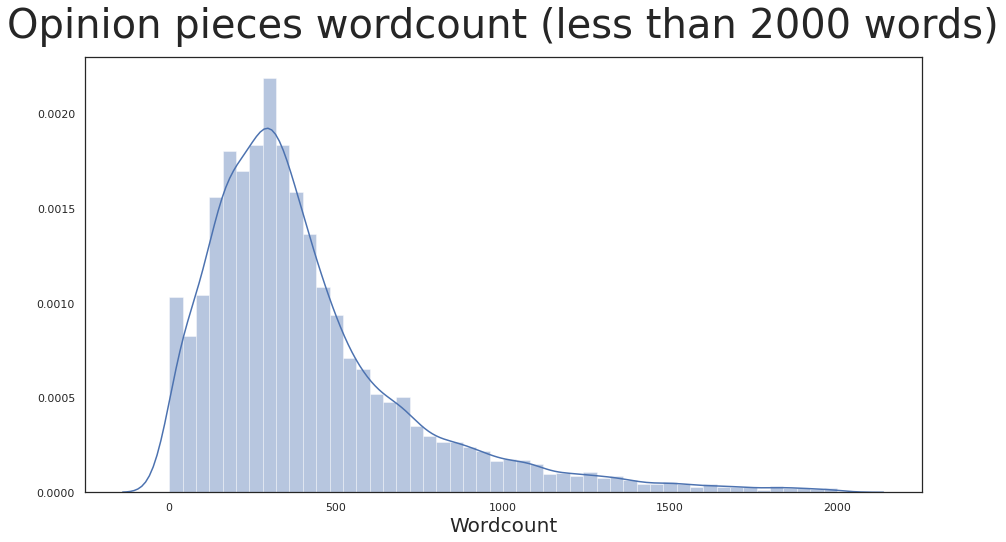

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_opinions[(df_opinions['wordcount'] < 2000)]['wordcount'])
g.set_xlabel('Wordcount', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Opinion pieces wordcount (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles_u = " ".join(df_opinions['text'].astype(str).tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_u = countwords(all_articles_u, en_stops)

#Decide how many words to print
#to_print = int(input("How many top words do you wish to print?"))
to_print = 30
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_u = sorted(wordcount_u.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

print("Opinion pieces")
mc_filtered_u = filter_mc(mc_u)

The most common 30 words are:

Opinion pieces
Most common words:

said : 39020
trump : 19191
also : 17161
us : 15960
biden : 15813
election : 14988
new : 14576
people : 13661
one : 13423
president : 12921
state : 12316
would : 12020
2020 : 9801
first : 9728
states : 9659
time : 9340
two : 8825
like : 7756
could : 7700
last : 7623
covid19 : 7578
day : 7542
من : 6724
years : 6720
news : 6711
police : 6663
november : 6658
year : 6587
many : 6575
government : 6508




In [ ]:
def write_word(word, number, dataset_name):
  if word == '6724':
    return
  with open('frequent_words_' + dataset_name + '.txt', 'a') as f:
    for i in range(0, int(number)):
      f.write(word + ' ')

def collect_most_common_words(words, counts, dataset_name):
  for i in range(0, len(words)):
    write_word(words[i], counts[i], dataset_name)

In [ ]:
names = list(mc_filtered_u.keys())
values = list(mc_filtered_u.values())
collect_most_common_words(names, values, 'opinions')

### Uninteresting dataset

In [ ]:
upload_from_drive('https://drive.google.com/file/d/13fdKm3q90jQMknTkUtJbyMebWDbjViMR/view?usp=sharing', 'uninteresting.csv')

In [ ]:
df_uninteresting = pd.read_csv('uninteresting.csv')
df_uninteresting.info()

In [ ]:
df_uninteresting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637411 entries, 0 to 637410
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    637411 non-null  object
dtypes: object(1)
memory usage: 4.9+ MB


In [ ]:
df_uninteresting = df_uninteresting.sample(n=20000)

In [ ]:
df_uninteresting['length'] = df_uninteresting['text'].astype(str).apply(len)
df_uninteresting['wordcount'] = df_uninteresting['text'].astype(str).apply(lambda row: len(row.split(' ')))

In [ ]:
df_uninteresting['length'].describe()

count    20000.000000
mean      1102.012100
std       1682.873664
min         12.000000
25%        237.000000
50%        650.000000
75%       1414.000000
max      73751.000000
Name: length, dtype: float64

In [ ]:
df_uninteresting['wordcount'].describe()

count    20000.000000
mean       229.111750
std        309.157764
min          6.000000
25%         62.000000
50%        142.000000
75%        290.000000
max      13588.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Blog posts length (less than 5000 characters)')

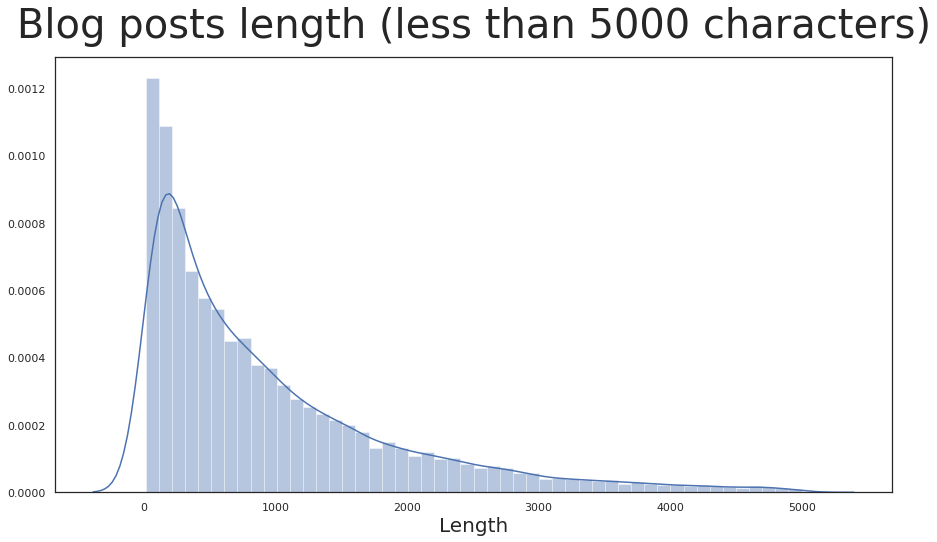

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_uninteresting[(df_uninteresting['length'] < 5000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Blog posts length (less than 5000 characters)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Blog posts wordcount (less than 2000 words)')

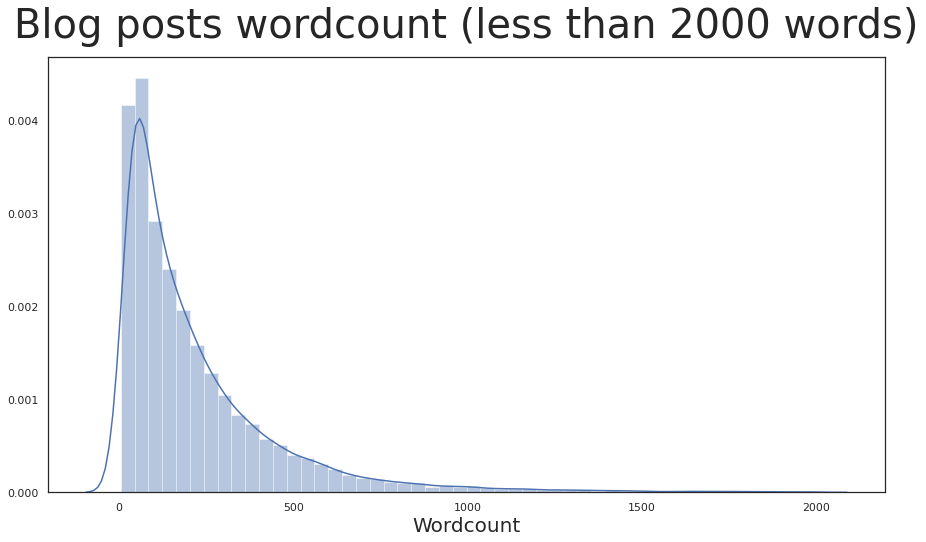

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_uninteresting[(df_uninteresting['wordcount'] < 2000)]['wordcount'])
g.set_xlabel('Wordcount', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Blog posts wordcount (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles_u = " ".join(df_uninteresting['text'].astype(str).tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_u = countwords(all_articles_u, en_stops)

#Decide how many words to print
#to_print = int(input("How many top words do you wish to print?"))
to_print = 30
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_u = sorted(wordcount_u.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

print("Opinion pieces")
mc_filtered_u = filter_mc(mc_u)

The most common 30 words are:

Opinion pieces
Most common words:

im : 17056
like : 16235
one : 12829
get : 11364
dont : 10941
urllink : 10857
time : 10418
know : 10145
really : 9618
go : 8880
think : 8647
well : 8633
would : 8417
people : 7935
good : 7862
got : 7677
going : 7214
back : 7040
see : 6759
day : 6652
much : 6463
want : 5910
even : 5588
love : 5487
went : 5483
today : 5450
way : 5166
say : 5097
ive : 5091
could : 5072




In [ ]:
names = list(mc_filtered_u.keys())
values = list(mc_filtered_u.values())
collect_most_common_words(names, values, 'uninteresting')

## Professionality detector
Following, there are the datasets used to train our professionality detector

### Low-quality
By taking inspiration from r/Fakeddit, we exploited Reddit’s characteristic of creating mono-thematic communities in our advantage. In particular, we were able to find r/savedyouaclick [2], a subreddit (a Reddit community) with almost 1.5 million subscribers whose theme is specifically sharing clickbait and low quality articles. From here, we were able to scrape 11080 articles labeled as “low-quality”.

This is the dataset directly from Reddit

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1K00_th_MsDr5yKqfjLxz2Jw3iVf6EAc-/view?usp=sharing', 'low_quality_articles.csv')
df = pd.read_csv('low_quality_articles.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,4,6,8,9,10,11,12,16,18,19,20,21,22,24,26,27,28,29,30,31,35,37,41,45,46,51,57,60,61,63,65,66,71,73,74,77,79,81,82,84,85,86,87,93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30997 entries, 0 to 30996
Data columns (total 94 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  8198 non-null   object 
 1   allow_live_comments            7088 non-null   object 
 2   author                         30997 non-null  object 
 3   author_flair_css_class         165 non-null    object 
 4   author_flair_richtext          14336 non-null  object 
 5   author_flair_text              109 non-null    object 
 6   author_flair_type              14336 non-null  object 
 7   author_fullname                19963 non-null  object 
 8   author_patreon_flair           10463 non-null  object 
 9   author_premium                 4462 non-null   object 
 10  awarders                       5784 non-null   object 
 11  can_mod_post                   19654 non-null  object 
 12  contest_mode                   28844 non-null 

In [ ]:
df['dummy'] = 1
df.groupby(by='domain').count().sort_values(by='dummy', ascending=False)['dummy'][:10]

domain
archive.is             6337
web.archive.org        6111
self.savedyouaclick    2335
youtube.com            1144
i.redd.it               918
streamable.com          570
youtu.be                501
archive.fo              306
unvis.it                305
unv.is                  294
Name: dummy, dtype: int64

First, we will be cleaning the dataset of low quality articles

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1easWKFpDhJhvQzQirqd1XGW-OiI4MA2j/view?usp=sharing','low_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ze3-ly3NZ-gd2Ray7t_FyIdpzcBeGOAc/view?usp=sharing','low_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1EHF2BAsD2SWycLza7drc7RiAbjIzCZr4/view?usp=sharing','low_quality_articles2.csv')
upload_from_drive('https://drive.google.com/file/d/1YkUQa-rRO_ykUoSkeo_a-YU2TlapaUac/view?usp=sharing','low_quality_articles3.csv')
upload_from_drive('https://drive.google.com/file/d/1bCIWMVuU13CHJUQUdSTEyqjtVFit4AXc/view?usp=sharing','low_quality_articles4.csv')
upload_from_drive('https://drive.google.com/file/d/1TnrUQJKfDWTxXqx8PHsoVFCVEZyNZV7E/view?usp=sharing','low_quality_articles5.csv')

In [ ]:
df_low = pd.DataFrame()
for i in range(0,6):
  df_low = pd.concat([df_low, pd.read_csv('low_quality_articles' + str(i) + '.csv')])

df_low = df_low.drop(columns=['url'], axis=1)
df_low['text'] = df_low['text'].astype(str)
df_low = df_low.drop_duplicates()
df_low = df_low[~df_low['text'].isna()]
df_low = df_low[df_low['text'] != 'nan']
df_low.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11688 entries, 0 to 334
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   publisher  11688 non-null  object
 1   text       11688 non-null  object
dtypes: object(2)
memory usage: 273.9+ KB


In [ ]:
df_low[df_low['publisher'] == 'cnn.com'][:5]['text'].tolist()

['New York (CNN Business) After several teasers and mini-events, Sony has finally revealed the price of its much-anticipated PlayStation 5.\n\nIt costs $499, putting it head to head with its rival, Microsoft\'s Xbox Series X, which likewise is going for $499.\n\nThe PS5 will be released on November 12 in the United States, Japan, Canada, Mexico, Australia, New Zealand and South Korea. For other countries, it\'s coming out on November 19. In a footnote, Sony said that China\'s launch date is still "under exploration."\n\nThe Xbox Series X is coming out on November 10, beating the PS5 to market by two full days. Microsoft is also selling a cheaper Series S for $299.\n\nCarolina Milanesi, a tech analyst at research firm Creative Strategies, said the difference in rival devices\' release dates won\'t make much of a difference in sales.\n\nRead More',
 'Milwaukee (CNN) Only one of the three men shot during a night of protests in Kenosha last month survived, and he\'s still reliving it every

Let's take a look at the main publishers

In [ ]:
df_low['dummy'] = 1
df_low.groupby(by='publisher').count().sort_values(by='dummy', ascending=False)[:10]

,text,dummy
publisher,,
web.archive.org,4370,4370
express.co.uk,166,166
businessinsider.com,135,135
cnn.com,131,131
yahoo.com,101,101
google.com,101,101
cnbc.com,90,90
forbes.com,89,89
cheatsheet.com,89,89


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles length')

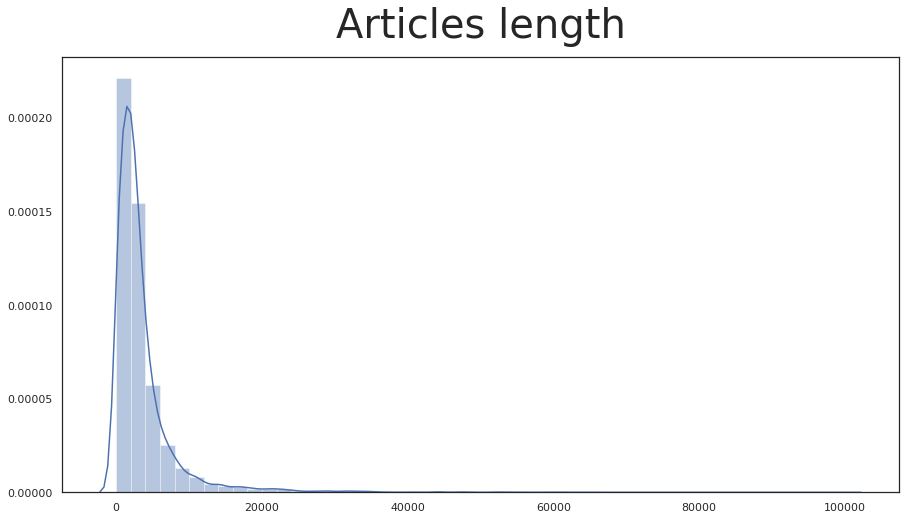

In [ ]:
df_low['length'] = df_low['text'].apply(len)
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_low['length'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length', fontsize = 40, pad=20)

In [ ]:
df_low['length'].describe()

count     11688.000000
mean       3503.773015
std        4825.374212
min          15.000000
25%        1137.000000
50%        2273.000000
75%        4009.250000
max      100000.000000
Name: length, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count')

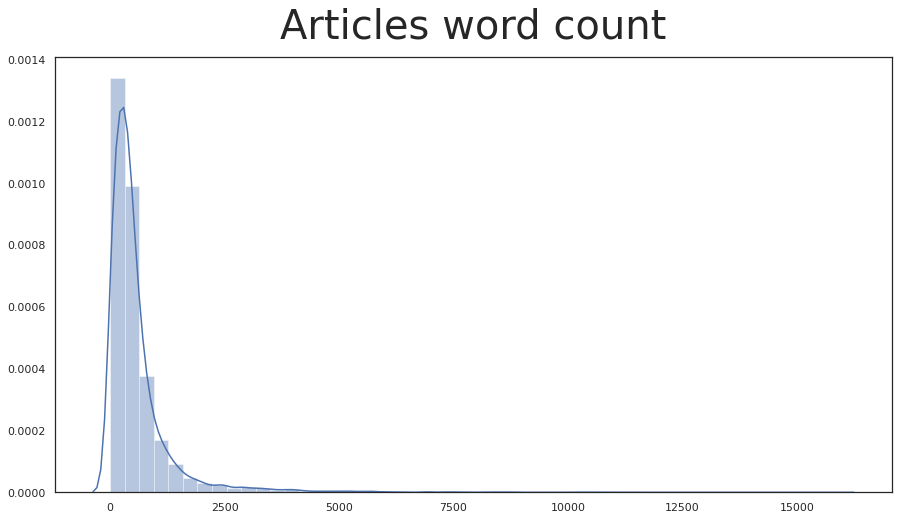

In [ ]:
df_low['wordcount'] = df_low['text'].apply(lambda row: len(row.split(" ")))
plt.figure(figsize = (15,8))
plt.title('Articles word count')
g = sns.distplot(df_low['wordcount'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count (less than 2000 words)')

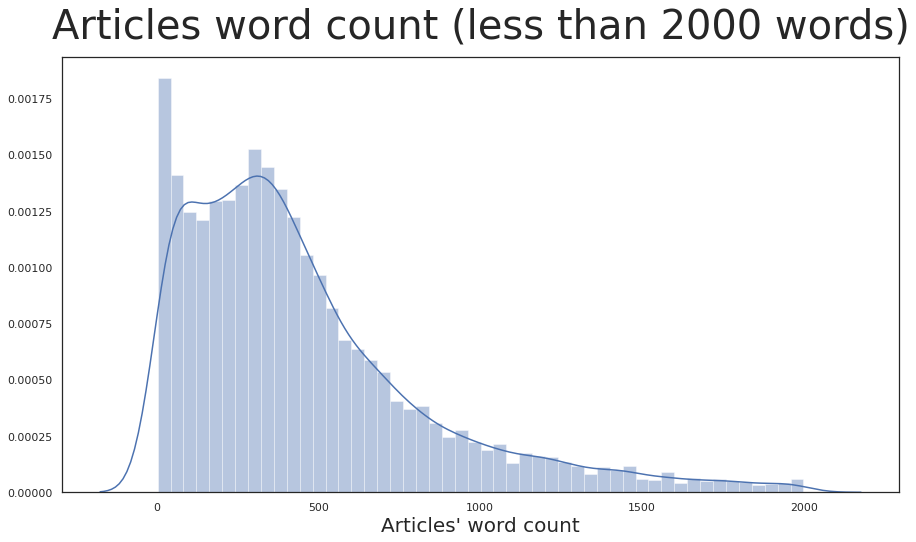

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles word count')
g = sns.distplot(df_low[df_low['wordcount'] < 2000]['wordcount'])
g.set_xlabel("Articles' word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
df_low[df_low['wordcount'] < 20]

,publisher,text,dummy,length,wordcount
2,apple.news,Opening story…\n\nClick hereTap here if the st...,1,110,17
23,cbsnews.com,Americans and the right to vote: Why it's not ...,1,63,12
115,yourdailysportfix.com,You might have toned your body to bring every ...,1,91,17
208,web.archive.org,The Wayback Machine requires your browser to s...,1,132,19
223,reddit.com,Press J to jump to the feed. Press question ma...,1,92,18
...,...,...,...,...,...
2209,buzzfeed.com,"During the shoot, Tetteh and Amoah posed for a...",1,77,15
2232,edition.cnn.com,"Sneaky panther seems ready to pounce on ""victi...",1,98,17
52,web.archive.org,He Pokes Nails Into A Lemon. The Result Is Ins...,1,57,11
171,ign.com,"If you buy something through this post, IGN ma...",1,93,19


In [ ]:
df_low['wordcount'].describe()

count    11688.00000
mean       581.36499
std        811.84190
min          3.00000
25%        188.00000
50%        374.50000
75%        659.00000
max      15872.00000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

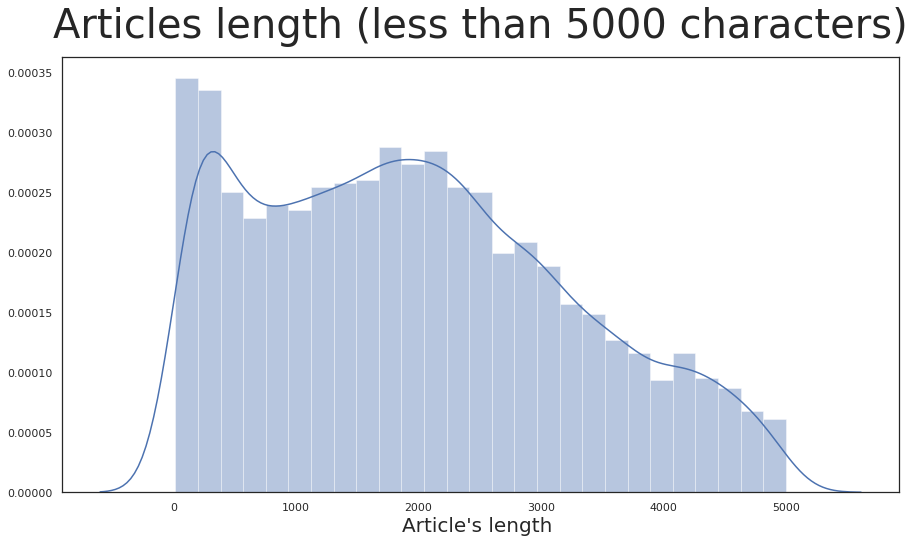

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_low[df_low['length'] < 5000]['length'])
g.set_xlabel("Article's length ", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

In [ ]:
df_low['length'].describe()

count     11688.000000
mean       3503.773015
std        4825.374212
min          15.000000
25%        1137.000000
50%        2273.000000
75%        4009.250000
max      100000.000000
Name: length, dtype: float64

In [ ]:
len(df_low[df_low['length'] < 100])

220

In [ ]:
len(df_low[df_low['length'] > 10000])

675

In [ ]:
df_low[df_low['length'] > 50000]['text'].tolist()

['CCFN Regolamento ufficiale del Capitolo 2 Stagione 4 Da Il team Competizioni di Fortnite\n\nCompetizione Campioni di Fortnite: regolamento ufficiale del Capitolo 2 Stagione 4\n\n\n\n1. Introduzione e accettazione\n\n\n\n1.1 Introduzione\n\n\n\nIl regolamento ufficiale della Competizione Campioni di Fortnite del Capitolo 2 Stagione 4 ("Regolamento") disciplina tutte le fasi della Competizione Campioni di Fortnite del Capitolo 2 Stagione 4 ("Competizione Campioni" o "Evento").\n\n\n\nIl regolamento è stato progettato per garantire l\'integrità delle partite competitive di Fortnite (le "Partite") organizzate nel corso dell\'Evento, e ha lo scopo di promuovere una sana competizione e di assicurare che tutte le partite competitive del gioco siano divertenti, eque e prive di comportamenti tossici (come definito di seguito).\n\n\n\n1.2 Accettazione\n\n\n\nPer partecipare all\'Evento, ogni giocatore (o un suo genitore o chi ne fa le veci, se il giocatore è "minorenne" secondo i termini defin

In [ ]:
df_low[df_low['length'] < 100]['text'].tolist()

["Americans and the right to vote: Why it's not easy for everyone",
 'You might have toned your body to bring every inch of your muscle in shape. Training for...',
 'Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts',
 'jo promoter says wait a little bit please',
 'Notice\n\nYou must log in to continue.',
 'Help me find out what this is\n\n\n\n1 / 2',
 'Research and publish the best content.',
 'Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts',
 'No ads, always HD experience with Gfycat Pro.',
 'Press J to jump to the feed. Press question mark to learn the rest of the keyboard shortcuts',
 'Inspired by the neal.fun website by Neal Agarwal..\n\nAll Rights Reserved 2020 - 2021 ©',
 "Just a moment...\n\nWe'll try your destination again in 15 seconds",
 'Not your computer? Use Guest mode to sign in privately. Learn more',
 'Please assign a menu to the primary menu location under menu',
 "Why You Won't S

It seems that most of these short articles were just scraped on the titles or where in the form of title + images. In any case, I'd say we can keep them

In [ ]:
all_articles = " ".join(df_low['text'].tolist())

In [ ]:
with open('all_articles.txt', 'w') as f:
  f.write(all_articles)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_low['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

one : 22311
like : 16005
would : 15673
said : 15547
people : 14455
time : 13953
also : 13611
new : 13563
even : 11172
get : 11040
could : 10787
first : 9827
years : 9203
us : 9005
make : 8334
many : 8204
may : 8198
know : 7882
two : 7850
way : 7805
dont : 7693
much : 7424
see : 7365
back : 7142
still : 7046
going : 6582
well : 6566
day : 6427
life : 6275
year : 6211




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'low_quality')

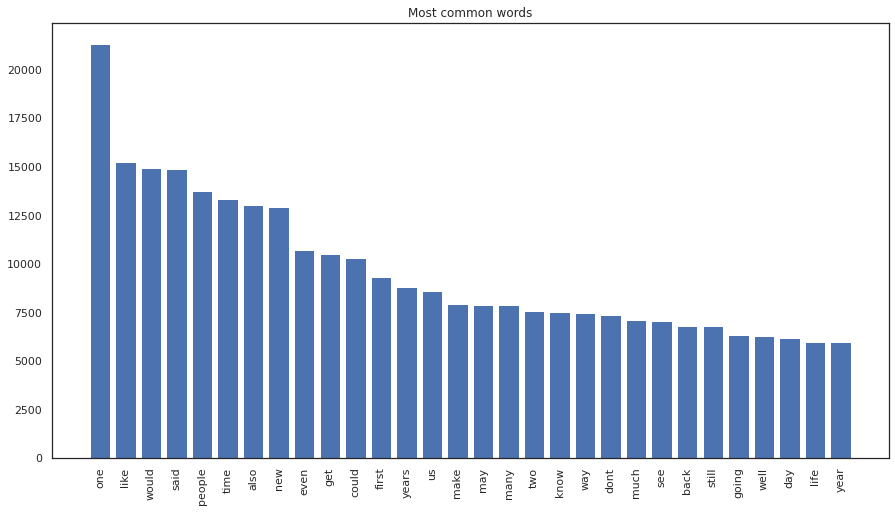

In [ ]:
plt.figure(figsize = (15,8))



plt.bar(range(len(mc_filtered)),values,tick_label=names)
plt.title('Most common words')
plt.tick_params(axis='x', labelrotation=90)

### High-quality: r/qualitynews

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1HFLSC5zIQTcbghGl6Q1eRUouMQv03Br0/view?usp=sharing', 'high_quality_articles0.csv')
upload_from_drive('https://drive.google.com/file/d/1ae_K2s7kG_s0htI-t97Rjx2A-nvBc7Id/view?usp=sharing', 'high_quality_articles1.csv')
upload_from_drive('https://drive.google.com/file/d/1Oua1qqQmPCCyc3eKf176EhBUS553rhS-/view?usp=sharing', 'high_quality_articles2.csv')

In [ ]:
df_high = pd.concat([pd.read_csv('high_quality_articles0.csv'), pd.read_csv('high_quality_articles1.csv'), pd.read_csv('high_quality_articles2.csv')])

df_high = df_high.drop(columns=['url'], axis=1)
df_high['text'] = df_high['text'].astype(str)
df_high = df_high[df_high['text'] != 'nan']
df_high = df_high.drop_duplicates()
df_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11695 entries, 0 to 2877
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   publisher  11695 non-null  object
 1   text       11695 non-null  object
dtypes: object(2)
memory usage: 274.1+ KB


In [ ]:
df_high['dummy'] = 1
df_high.groupby(by='publisher').count().sort_values(by='dummy', ascending=False)

,text,dummy
publisher,,
reuters.com,2344,2344
bbc.com,2181,2181
npr.org,1106,1106
theguardian.com,898,898
aljazeera.com,848,848
...,...,...
hubpages.com,1,1
hosted2.ap.org,1,1
hongkongfp.com,1,1


In [ ]:
df_high['length'] = df_high['text'].apply(len)
df_high['wordcount'] = df_high['text'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_high['length'].describe()

count     11695.000000
mean       3787.423514
std        4256.612172
min          21.000000
25%        1215.000000
50%        3030.000000
75%        5066.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    11695.000000
mean       593.706114
std        671.725572
min          1.000000
25%        191.000000
50%        471.000000
75%        790.000000
max      14248.000000
Name: wordcount, dtype: float64

In [ ]:
df_high = df_high[df_high['length'] >= 100]
df_high = df_high[df_high['wordcount'] >= 20]

In [ ]:
df_high['length'].describe()

count     11641.000000
mean       3804.584744
std        4258.991615
min         104.000000
25%        1244.000000
50%        3051.000000
75%        5074.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    11641.000000
mean       596.396358
std        672.116687
min         20.000000
25%        197.000000
50%        474.000000
75%        793.000000
max      14248.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

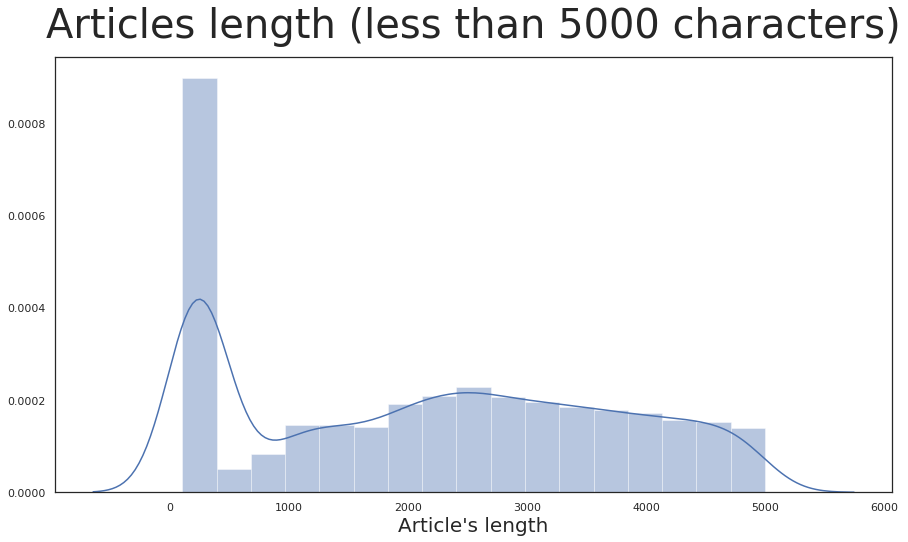

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_high[df_high['length'] < 5000]['length'])
g.set_xlabel("Article's length", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count (less than 2000 words)')

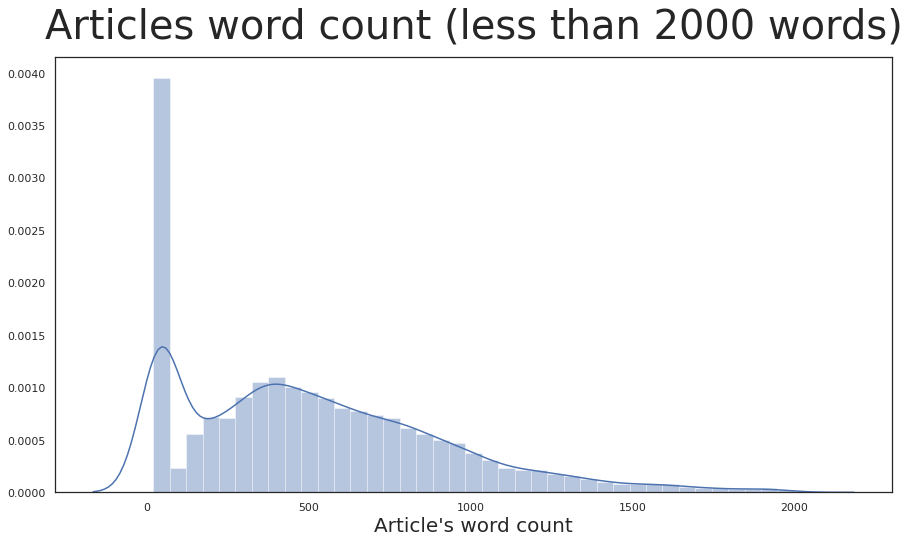

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_high[df_high['wordcount'] < 2000]['wordcount'])
g.set_xlabel("Article's word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
df_high = df_high.drop(columns=['length'], axis=1)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_high['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 58883
us : 24294
would : 16563
people : 16334
trump : 14872
also : 13720
one : 13539
new : 13411
government : 13004
president : 12642
state : 11515
two : 10467
police : 10296
told : 10188
could : 9365
last : 8986
states : 8587
news : 8578
years : 8332
year : 8121
says : 7653
according : 7634
time : 7286
reuters : 7240
officials : 7116
security : 7027
many : 6983
first : 6958
court : 6930
united : 6508




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'high_quality_qualitynews')

### High-quality: r/news

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1fw7nWRBn5ssLUjd2A2R-CREzeqZptroD/view?usp=sharing', 'high_quality_articles_second_0.csv')
upload_from_drive('https://drive.google.com/file/d/1Ai5vV2m9rTauM_LYMnrNt4FM1RBXByHP/view?usp=sharing', 'high_quality_articles_second_1.csv')
upload_from_drive('https://drive.google.com/file/d/1bP-qE5kwmUKX0To40PMDFI2baQxhT-eA/view?usp=sharing', 'high_quality_articles_second_2.csv')
upload_from_drive('https://drive.google.com/file/d/1lQjDTsMf-EgIyyaNil0N9P5UeiSDfqlG/view?usp=sharing', 'high_quality_articles_second_3.csv')
upload_from_drive('https://drive.google.com/file/d/1rBeGJiLrlj-4OT8ez06DDzyHyN8H6Eet/view?usp=sharing', 'high_quality_articles_second_4.csv')
upload_from_drive('https://drive.google.com/file/d/1u_LJ1E4c_ZjLVABy6ySUtyId23zx4AcG/view?usp=sharing', 'high_quality_articles_second_5.csv')

In [ ]:
df_high = pd.DataFrame()
for i in range(0,6):
  df_high = pd.concat([df_high, pd.read_csv('high_quality_articles_second_' + str(i) + '.csv')])

df_high = df_high.drop(columns=['url'], axis=1)
df_high['text'] = df_high['text'].astype(str)
df_high = df_high[df_high['text'] != 'nan']
df_high = df_high.drop_duplicates()
df_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17948 entries, 0 to 4316
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   publisher  17948 non-null  object
 1   text       17948 non-null  object
dtypes: object(2)
memory usage: 420.7+ KB


In [ ]:
df_high['dummy'] = 1
df_high.groupby(by='publisher').count().sort_values(by='dummy', ascending=False)

,text,dummy
publisher,,
popularnews.in,2256,2256
corealpha.org,1315,1315
en.neroonews.com,1144,1144
newspotng.com,1052,1052
techfans.co.uk,922,922
...,...,...
idcp.com.au,1,1
icrowdnewswire.com,1,1
icilpk.com,1,1


In [ ]:
df_high['length'] = df_high['text'].apply(len)
df_high['wordcount'] = df_high['text'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_high['length'].describe()

count    17948.000000
mean      3062.945398
std       3685.894023
min         19.000000
25%       1354.750000
50%       2192.000000
75%       3518.000000
max      87230.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    17948.000000
mean       486.531758
std        583.391554
min          1.000000
25%        214.000000
50%        348.000000
75%        559.000000
max      12177.000000
Name: wordcount, dtype: float64

In [ ]:
df_high = df_high[df_high['length'] >= 100]
df_high = df_high[df_high['wordcount'] >= 20]

In [ ]:
df_high['length'].describe()

count    17782.000000
mean      3090.606400
std       3691.856514
min        103.000000
25%       1380.000000
50%       2206.500000
75%       3538.500000
max      87230.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    17782.000000
mean       490.953042
std        584.302436
min         20.000000
25%        218.000000
50%        350.000000
75%        562.000000
max      12177.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

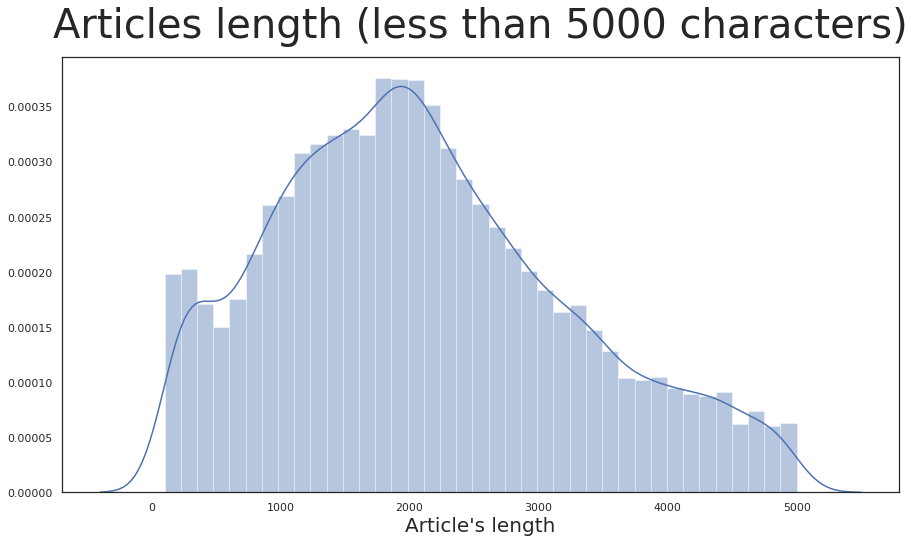

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_high[df_high['length'] < 5000]['length'])
g.set_xlabel("Article's length", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count (less than 2000 words)')

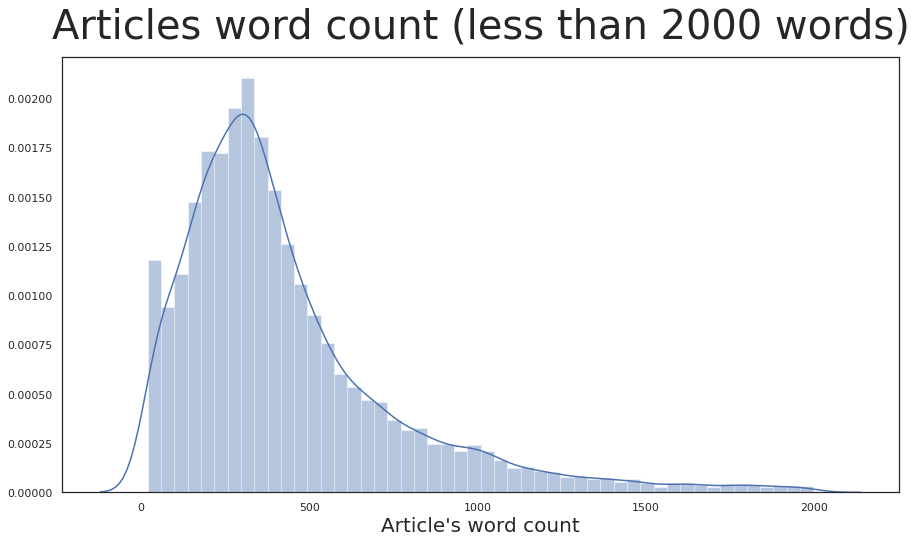

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_high[df_high['wordcount'] < 2000]['wordcount'])
g.set_xlabel("Article's word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_high['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 39509
also : 20051
new : 17955
one : 17256
people : 14169
us : 13453
would : 13217
trump : 11933
time : 11797
state : 10924
police : 10738
two : 10149
like : 9954
first : 9802
2020 : 9524
president : 9319
في : 9164
من : 8963
last : 8311
could : 8306
years : 8191
get : 8112
covid19 : 8047
year : 7976
day : 7743
government : 7620
many : 7454
even : 7322
may : 7039
october : 6987




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

names_ = []
for name in names:
  if name in ['في', 'من']:
    continue
  names_.append(name)

collect_most_common_words(names, values, 'high_quality_news')

### High-quality: newspaper

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1tw4kiikVptTxoEo9tPXLB07bj5MJGg7x/view?usp=sharing', 'high_quality_articles_third.csv')

In [ ]:
df_high = pd.read_csv('high_quality_articles_third.csv')
df_high['text'] = df_high['text'].astype(str)
df_high = df_high[df_high['text'] != 'nan']
df_high = df_high.drop(columns=['url'], axis=1)
df_high.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15369 entries, 0 to 15436
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15369 non-null  object
dtypes: object(1)
memory usage: 240.1+ KB


In [ ]:
df_high['length'] = df_high['text'].apply(len)
df_high['wordcount'] = df_high['text'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_high['length'].describe()

count     15369.000000
mean       6648.788145
std        7663.130854
min          41.000000
25%        1276.000000
50%        4308.000000
75%        9254.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    15369.000000
mean      1058.294099
std       1228.896887
min          1.000000
25%        197.000000
50%        690.000000
75%       1471.000000
max      17678.000000
Name: wordcount, dtype: float64

["JULY MARKS the 55th anniversary of the Civil Rights Act, which outlawed discrimination on the basis of race, colour, religion, sex, or national origin. It also enforced desegregation of the government-run school system nationwide, largely ending the practice of educational apartheid. But while desegregation transformed America's education system, the way it was implemented by discriminatory school boards in the South was harmful to black teachers. A new paper by Owen Thompson, an economist at Williams College, shows there was a dramatic decline in the employment of African-American teachers in the aftermath of desegregation. The policies behind that decline have contributed to lower employment for African-American educators in the decades since.\n\nIn 1954 the Supreme Court ruled in the case of Brown v Board of Education that “in the field of public education the doctrine of ‘separate but equal’ has no place.” Ten years later, less than 5% of black children in the Southern states of 

In [ ]:
df_high[df_high['wordcount'] < 50]['text'].tolist()

['"We would like to look at why there was a fall in oxygen in the water... I don\'t have an answer to this yet," he said, quoted by Reuters.',
 'In Warsaw, hundreds of people marched from the court to the home of Jaroslaw Kaczynski - who heads the governing Law and Justice party - to vent their anger at the ruling. Some held candles or carried signs with the word "torture" on them.',
 'The British offer is not for all residents of Hong Kong, but only those holding a British National Overseas (BNO) passport. Only those born before the 1997 handover of the territory to China have the right to hold one.',
 'He added: "As more and more energy-intensive manufacturing industries in Scotland close down, then it is inevitable that those which the Scottish economy so heavily rely on will stand out above the rest in terms of their emissions.',
 '"The BMC are working closely with music industry companies across the board to support further development for the betterment of black executives, and w

In [ ]:
df_high = df_high[df_high['length'] >= 100]
df_high = df_high[df_high['wordcount'] >= 20]

In [ ]:
df_high['length'].describe()

count     15228.000000
mean       6705.754071
std        7675.018281
min         103.000000
25%        1348.000000
50%        4387.000000
75%        9314.000000
max      100000.000000
Name: length, dtype: float64

In [ ]:
df_high['wordcount'].describe()

count    15228.000000
mean      1067.981678
std       1230.423214
min         20.000000
25%        214.000000
50%        700.000000
75%       1483.000000
max      17678.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles length (less than 5000 characters)')

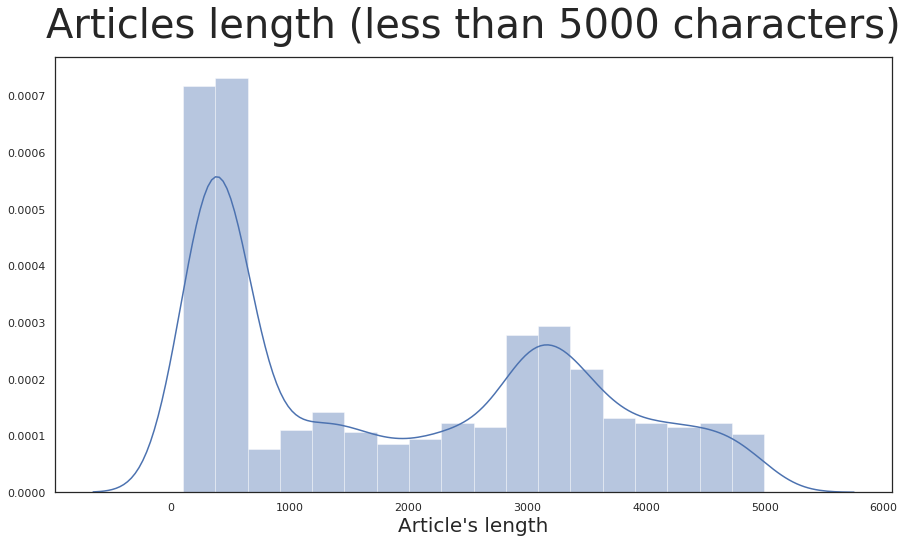

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_high[df_high['length'] < 5000]['length'])
g.set_xlabel("Article's length", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles length (less than 5000 characters)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count (less than 2000 words)')

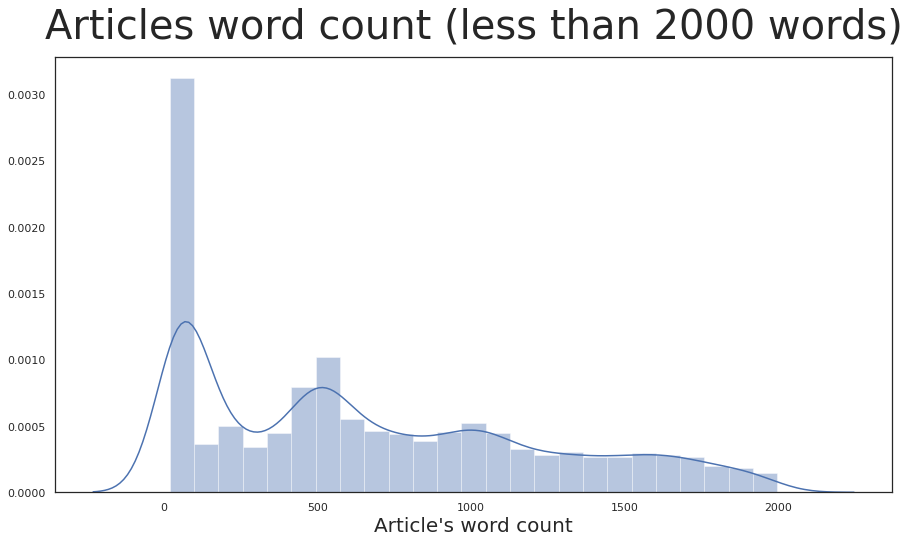

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_high[df_high['wordcount'] < 2000]['wordcount'])
g.set_xlabel("Article's word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count (less than 2000 words)', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_high['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

would : 44657
said : 40216
one : 38993
us : 35739
people : 33745
states : 32792
trump : 31620
new : 31218
also : 28667
united : 26816
could : 25626
even : 24240
many : 22763
president : 21536
time : 20960
mr : 20919
like : 20490
years : 20209
first : 19372
world : 19136
two : 19010
government : 18729
china : 17830
may : 17420
state : 17227
political : 16856
much : 15030
year : 15022
american : 14840
countries : 14444




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'high_quality_newspaper')

## Claim detection

### Atanova et al, 2019

### New dataset

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1oVJ1lqStEyjzSTqoSdCyhoTXizQv8PPt/view?usp=sharing', 'checkworthy_claims.csv')

In [ ]:
df_claims = pd.read_csv('checkworthy_claims.csv')

In [ ]:
df_claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17580 entries, 0 to 17579
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  17580 non-null  object
 1   author    17580 non-null  object
 2   target    17580 non-null  object
 3   ruling    17580 non-null  object
 4   date      17580 non-null  object
dtypes: object(5)
memory usage: 686.8+ KB


In [ ]:
df_claims[df_claims.sentence.str.startswith("<")]

,sentence,author,target,ruling,date
1230,<p>Says &quot;10% of U.S. children are Texans....,James White,[],true,2020-01-31
1231,<p>Says drinking a bleach solution will preven...,Tweets,[],pants-fire,2020-01-30
1232,<p>&quot;Vice President Biden threatened a for...,Rick Scott,['Joe Biden'],false,2020-01-30
1233,<p>Says a &quot;Clorox bottle claimed it could...,Facebook posts,[],false,2020-01-30
1235,<p>Says some of the names that may be purged f...,Robert Spindell,[],barely-true,2020-01-30
...,...,...,...,...,...
17554,"<p>\""In 1972, we had a 179,000 human beings in...",Mike Gravel,[],pants-fire,2007-08-30
17555,"<p>\""In state after state, polls make clear th...",John McCain,[],mostly-true,2007-08-30
17559,"<p>\""The president is brain-dead.\""</p>",Joe Biden,[],pants-fire,2007-08-24
17567,"<p>\""Let's pay attention to kids who are not g...",Hillary Clinton,[],true,2007-08-21


In [ ]:
import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

df_claims["clean_sentence"] = df_claims["sentence"].apply(cleanhtml)

In [ ]:
df_claims['length'] = df_claims['clean_sentence'].apply(len)
df_claims['wordcount'] = df_claims['clean_sentence'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_claims['length'].describe()

count    17580.000000
mean       112.121615
std         47.390076
min         11.000000
25%         78.000000
50%        103.000000
75%        138.000000
max        862.000000
Name: length, dtype: float64

In [ ]:
df_claims['wordcount'].describe()

count    17580.000000
mean        18.033333
std          8.172992
min          2.000000
25%         12.000000
50%         16.000000
75%         22.000000
max         78.000000
Name: wordcount, dtype: float64

In [ ]:
df_claims[df_claims['wordcount'] < 5]

,sentence,author,target,ruling,date,clean_sentence,length,wordcount
198,"""Wayfair CEO steps down.""",Viral image,[],false,2020-07-20,"""Wayfair CEO steps down.""",25,4
1143,"""Dinesh D'Souza passed away.\""",Bloggers,[],pants-fire,2020-02-18,"""Dinesh D'Souza passed away.\""",30,4
2405,<p>On tax increases.</p>,Levar Stoney,[],half-flip,2019-03-19,On tax increases.,17,3
2701,<p>&quot;Principal bans candy canes.&quot;</p>...,Bloggers,[],mostly-true,2018-12-11,Principal bans candy canes.\r\n,31,4
3053,<p>California &quot;is hemorrhaging population...,Ted Cruz,"[""Beto O'Rourke""]",barely-true,2018-09-28,California is hemorrhaging population.\r\n,42,4
...,...,...,...,...,...,...,...,...
17130,"\""Fidel Castro endorses Obama.\""",Republican Party of Florida,[],pants-fire,2008-06-05,"\""Fidel Castro endorses Obama.\""",32,4
17344,"\""Ronald Reagan did amnesty.\""",Rudy Giuliani,[],true,2008-01-06,"\""Ronald Reagan did amnesty.\""",30,4
17458,"\""The founders advised non-interventionism.\""",Ron Paul,[],mostly-true,2007-10-22,"\""The founders advised non-interventionism.\""",45,4
17524,"\""I'm pro-life. He's not.\""",Sam Brownback,[],false,2007-09-12,"\""I'm pro-life. He's not.\""",27,4


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sentences length')

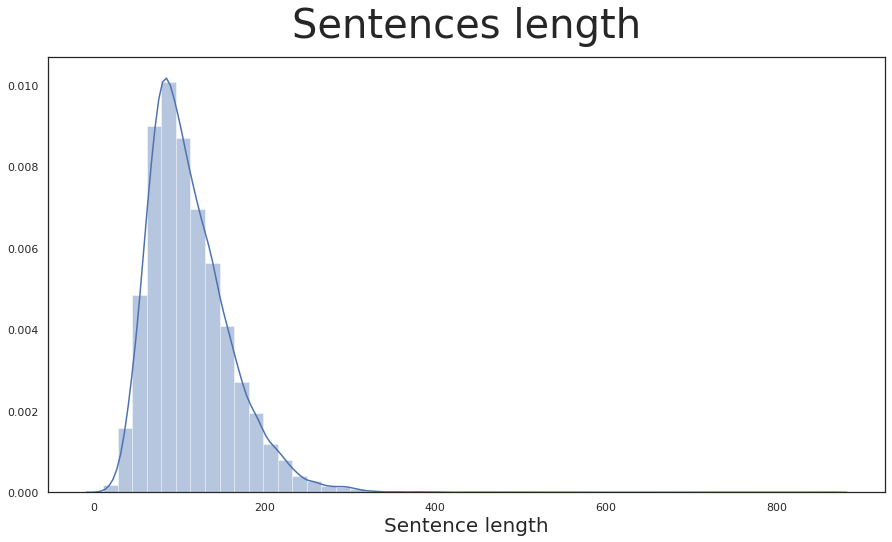

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_claims[df_claims['length'] < 5000]['length'])
g.set_xlabel("Sentence length", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Sentences length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sentences word count')

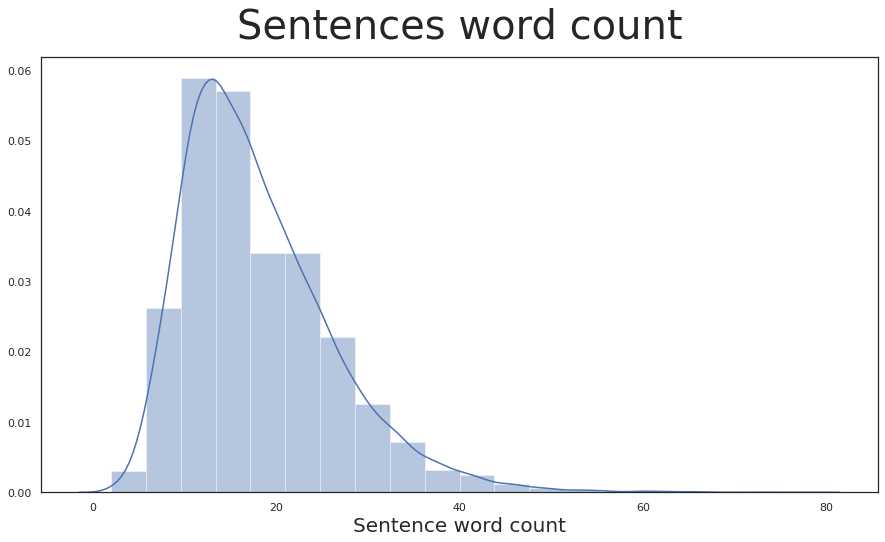

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_claims['wordcount'], bins=20)
g.set_xlabel("Sentence word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Sentences word count', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_claims['clean_sentence'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

says : 2610
percent : 1522
rntsays : 1442
state : 1124
people : 1077
tax : 1001
president : 993
obama : 991
health : 923
us : 835
million : 809
would : 804
new : 777
states : 771
years : 762
year : 737
care : 736
one : 733
said : 702
trump : 622
bill : 589
jobs : 570
every : 552
billion : 548
voted : 538
rntthe : 527
texas : 525
federal : 524
last : 506
barack : 495




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'claim_detection')

Text(0.5, 1.0, 'Ratings across the dataset')

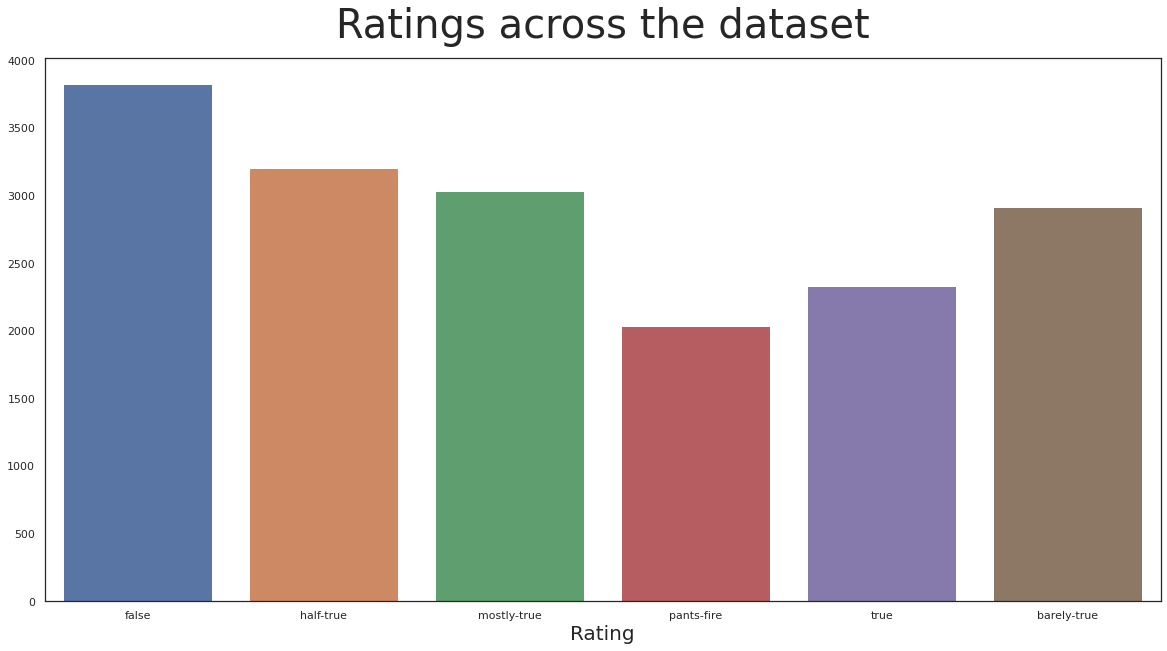

In [ ]:
plt.figure(figsize=(20,10))
g = sns.countplot(x="ruling", data=df_claims[df_claims['ruling'].isin(['false','half-true','mostly-true','pants-fire','true', 'barely-true'])])
g.set_xlabel("Rating", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Ratings across the dataset', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Most fact-checked people')

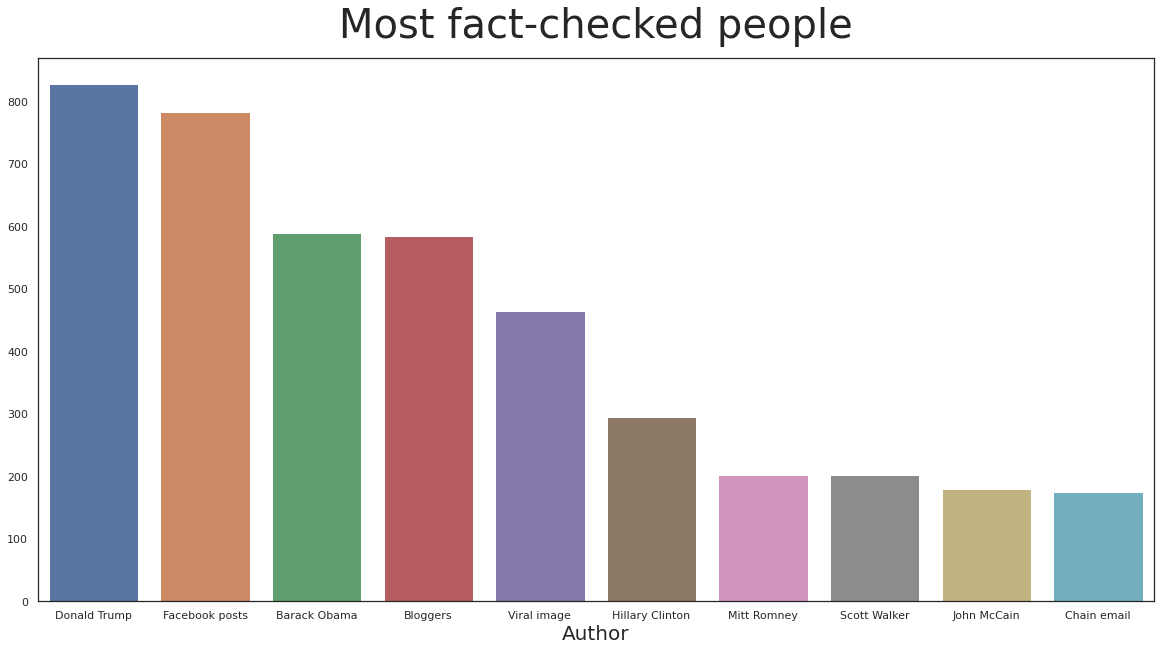

In [ ]:
plt.figure(figsize=(20,10))
g = sns.countplot(x="author", data=df_claims, order=df_claims.groupby(by='author').count().sort_values(by='clean_sentence', ascending=False).index[:10])
g.set_xlabel("Author", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Most fact-checked people', fontsize = 40, pad=20)

Now, it's the part dedicated to the negative samples (movie dataset)

In [ ]:
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip

--2020-11-17 13:55:11--  http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 52.201.128.190
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|52.201.128.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  8.89MB/s    in 1.1s    

2020-11-17 13:55:12 (8.89 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]



In [ ]:
!unzip cornell_movie_dialogs_corpus.zip

Archive:  cornell_movie_dialogs_corpus.zip
   creating: cornell movie-dialogs corpus/
  inflating: cornell movie-dialogs corpus/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cornell movie-dialogs corpus/
  inflating: __MACOSX/cornell movie-dialogs corpus/._.DS_Store  
  inflating: cornell movie-dialogs corpus/chameleons.pdf  
  inflating: __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf  
  inflating: cornell movie-dialogs corpus/movie_characters_metadata.txt  
  inflating: cornell movie-dialogs corpus/movie_conversations.txt  
  inflating: cornell movie-dialogs corpus/movie_lines.txt  
  inflating: cornell movie-dialogs corpus/movie_titles_metadata.txt  
  inflating: cornell movie-dialogs corpus/raw_script_urls.txt  
  inflating: cornell movie-dialogs corpus/README.txt  
  inflating: __MACOSX/cornell movie-dialogs corpus/._README.txt  


In [ ]:
lines_raw = []
with open("cornell movie-dialogs corpus/movie_lines.txt", "rb") as f:
  for line_raw in f.readlines():
    lines_raw.append(line_raw)

In [ ]:
lines = []

for line_raw in lines_raw:
  try:
    line_raw = str(line_raw)
  except Exception as e:
    print("Error")
    continue
  
  line_split = line_raw.split("+")
  line_split = list(filter(lambda x: x != '' and x != '$', line_split))
  line = {}
  line["line"] = line_split[-1][:-3]
  line["character"] = line_split[-2]
  line["movie_id"] = line_split[2].replace(" ","")
  line["len"] = len(line["line"])
  lines.append(line)

In [ ]:
df_movie = pd.DataFrame(lines)
print(len(df_movie))
df_movie.head()

304713


,line,character,movie_id,len
0,They do not!,BIANCA,m0,13
1,They do to!,CAMERON,m0,12
2,I hope so.,BIANCA,m0,11
3,She okay?,CAMERON,m0,10
4,Let's go.,BIANCA,m0,10


We also need to add info on the movies, before eliminating some of the rows to get a balanced final dataset.

In [ ]:
movies_raw = []
with open("cornell movie-dialogs corpus/movie_titles_metadata.txt", "rb") as f:
  for movie_raw in f.readlines():
    movies_raw.append(movie_raw)

In [ ]:
movies = []

for movie_raw in movies_raw:
  try:
    movie_raw = str(movie_raw)
  except Exception as e:
    print("Error")
    continue
  
  movie_split = movie_raw.split("+")
  movie_split = list(filter(lambda x: x != '' and x != '$', movie_split))
  movie = {}
  movie["movie_id"] = movie_split[0][2:].replace(" ", "")
  movie["title"] = movie_split[1]
  movie["score"] = movie_split[3]
  movie["genres"] = movie_split[-1][:-3]
  movies.append(movie)

In [ ]:
df_movie_info = pd.DataFrame(movies)
print(len(df_movie_info))
df_movie_info.head()

617


,movie_id,title,score,genres
0,m0,10 things i hate about you,6.90,"['comedy', 'romance']"
1,m1,1492: conquest of paradise,6.20,"['adventure', 'biography', 'drama', 'history']"
2,m2,15 minutes,6.10,"['action', 'crime', 'drama', 'thriller']"
3,m3,2001: a space odyssey,8.40,"['adventure', 'mystery', 'sci-fi']"
4,m4,48 hrs.,6.90,"['action', 'comedy', 'crime', 'drama', 'thril..."


In [ ]:
df_lines = pd.merge(df_movie, df_movie_info, on='movie_id')

In [ ]:
df_lines.head()

,line,character,movie_id,len,title,score,genres
0,They do not!,BIANCA,m0,13,10 things i hate about you,6.90,"['comedy', 'romance']"
1,They do to!,CAMERON,m0,12,10 things i hate about you,6.90,"['comedy', 'romance']"
2,I hope so.,BIANCA,m0,11,10 things i hate about you,6.90,"['comedy', 'romance']"
3,She okay?,CAMERON,m0,10,10 things i hate about you,6.90,"['comedy', 'romance']"
4,Let's go.,BIANCA,m0,10,10 things i hate about you,6.90,"['comedy', 'romance']"


In [ ]:
df_lines = df_lines[df_lines['len'] < 500]
df_lines = df_lines[df_lines['score'].astype(float) > 7.0]

In [ ]:
len(df_lines)

162494

In [ ]:
genres_to_remove = ["history", "sci-fi", "fantasy", "horror"]

for genre in genres_to_remove:
  df_lines[genre] = df_lines["genres"].apply(lambda row: 1 if genre in row else 0)

df_lines["is_genre_to_remove"] = df_lines.apply(lambda row: 1 if row['history'] == 1 or row['sci-fi'] == 1 or row['fantasy'] == 1 or row['horror'] == 1 else 0, axis=1)

In [ ]:
df_lines = df_lines[df_lines["is_genre_to_remove"] == 0]
len(df_lines)

118125

In [ ]:
df_lines = df_lines[df_lines['line'] != '']
df_lines.sample(n=26000)

,line,character,movie_id,len,title,score,genres,history,sci-fi,fantasy,horror,is_genre_to_remove
6422,Yes.,MOZART,m16,5,amadeus,8.40,"['biography', 'drama', 'music']",0,0,0,0,0
127809,"One napkin, coming up. I wish we had some ch...",BUD,m246,72,the apartment,8.40,"['romance', 'comedy', 'drama']",0,0,0,0,0
77825,You haven't seen her yet?,SWANA,m149,26,ninotchka,7.90,"['comedy', 'romance']",0,0,0,0,0
278205,No.,CALLOWAY,m558,4,the third man,8.50,"['film-noir', 'mystery', 'thriller']",0,0,0,0,0
144379,What's wrong?,VIOLET,m281,14,bound,7.50,"['crime', 'drama', 'thriller']",0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
93045,I like all varietals. I just don't generally ...,MILES,m178,154,sideways,7.80,"['comedy', 'drama', 'romance']",0,0,0,0,0
203403,It's okay. Happened a long time ago. He was...,WILL,m398,80,insomnia,7.30,"['crime', 'drama', 'mystery', 'thriller']",0,0,0,0,0
141611,What's that?,DETECTIVE #1,m276,13,blow,7.40,"['biography', 'crime', 'drama']",0,0,0,0,0
52694,Not at all.,PETER,m103,13,it happened one night,8.30,"['comedy', 'romance']",0,0,0,0,0


In [ ]:
df_lines['length'] = df_lines['line'].apply(len)
df_lines['wordcount'] = df_lines['line'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_lines['length'].describe()

count    118121.000000
mean         56.028420
std          59.011145
min           1.000000
25%          20.000000
50%          36.000000
75%          70.000000
max         499.000000
Name: length, dtype: float64

In [ ]:
df_lines['wordcount'].describe()

count    118121.000000
mean         11.803286
std          11.518206
min           2.000000
25%           5.000000
50%           8.000000
75%          15.000000
max         118.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Lines length')

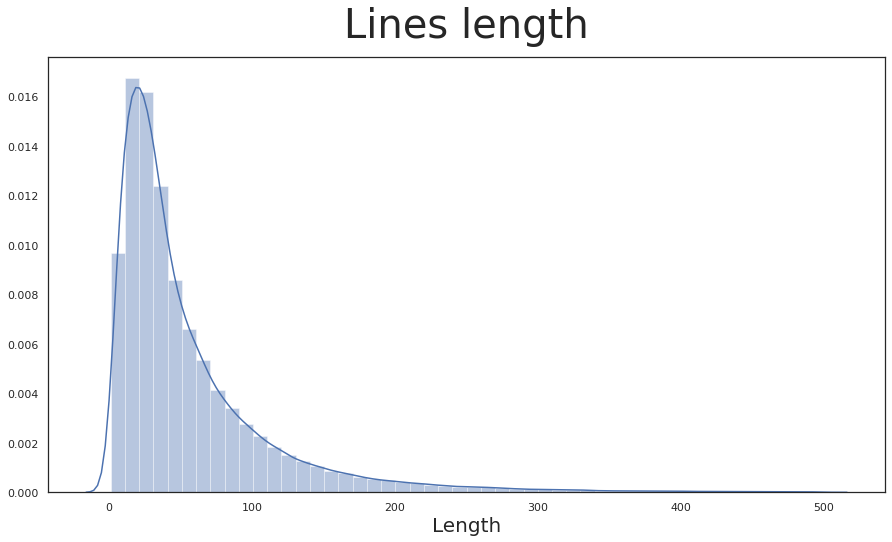

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_lines[df_lines['length'] < 5000]['length'])
g.set_xlabel("Length", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Lines length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Lines word count')

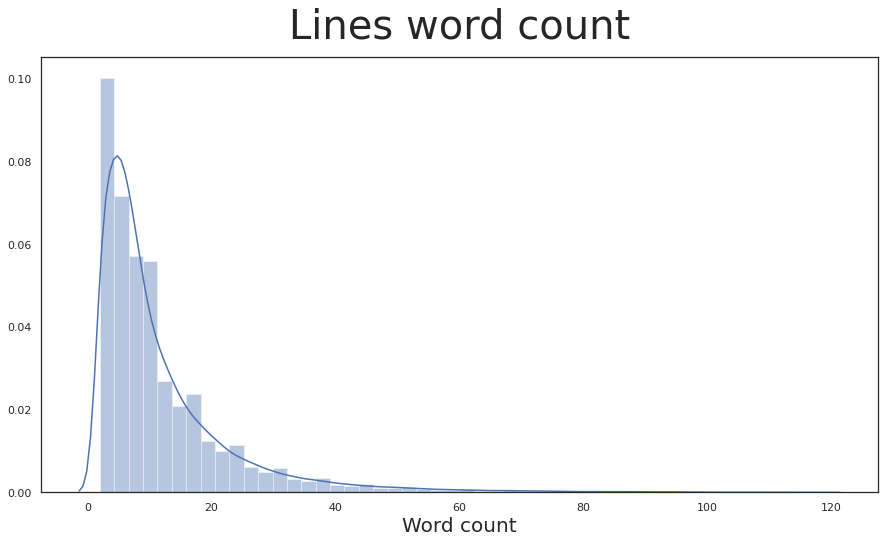

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_lines['wordcount'])
g.set_xlabel("Word count", fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Lines word count', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_lines['line'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

dont : 10302
im : 9058
know : 8888
like : 6092
get : 5588
youre : 5327
well : 5254
want : 4776
got : 4733
thats : 4519
think : 4231
right : 4015
one : 3924
go : 3902
going : 3427
see : 3419
oh : 3311
yes : 3190
good : 3129
yeah : 3034
tell : 2986
ill : 2972
come : 2719
hes : 2710
say : 2673
time : 2498
cant : 2495
didnt : 2402
would : 2388
back : 2342




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'movie_lines')

## Agreement detection

In [ ]:
upload_from_drive("https://drive.google.com/file/d/1x8n4QkP9izTnaYr8awm0sSDmRZYPkHXl/view?usp=sharing", 'final_factcheck_articles.csv')

In [ ]:
df_agree = pd.read_csv('final_factcheck_articles.csv')

In [ ]:
def translateLanguageCode(row):
  if row == 'en':
    return 'English'
  if row == 'pt':
    return 'Portuguese'
  if row == 'es':
    return 'Spanish'
  if row == 'hi':
    return 'Hindi'
  if row == 'it':
    return 'Italian'
  if row == 'te':
    return 'Telugu'
  if row == 'fr':
    return 'French'
  if row == 'ar':
    return 'Arabic'
  if row == 'ur':
    return 'Urdu'
  if row == 'pa':
    return 'Punjabi'
  if row == 'mr':
    return 'Marathi'
  if row == 'ml':
    return 'Malayam'
  if row == 'bn':
    return 'Bengali'
  if row == 'ta':
    return 'Tamil'
  if row == 'gu':
    return 'Gujarati'
  if row == 'or':
    return 'Oriya'
  if row == 'nl':
    return 'Dutch'

#Correct some of the language code info
def adjustLanguageCode(row):
  if row in ['zh', 'si', 'id']:
    return 'en'
  if row in ['th', 'kn']:
    return 'None'
  if row == 'pt-pt':
    return 'pt'
  return row

df_agree['languageCode'] = df_agree['languageCode'].apply(adjustLanguageCode)
df_agree['language'] = df_agree['languageCode'].apply(translateLanguageCode)

Text(0.5, 1.0, 'Number of articles\nper language')

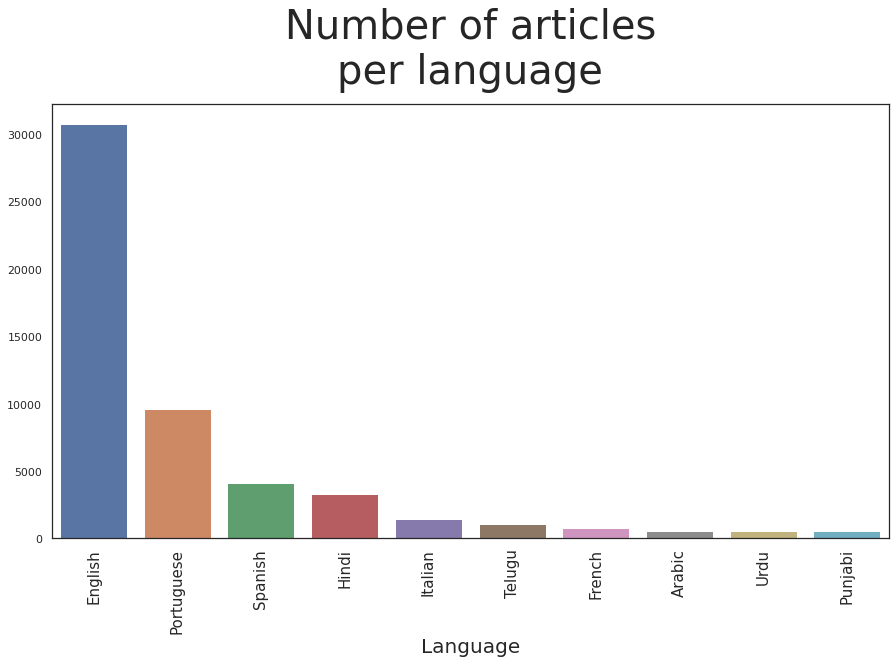

In [ ]:
sns.set(font_scale=1)
sns.set_style('white')
plt.figure(figsize = (15,8))
plt.title('Number of articles per language')
plt.xticks(rotation=90, fontsize=15)
g = sns.countplot(data=df_agree, x='language', order = df_agree['language'].value_counts().index[:10])
g.set_xlabel('Language', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper language', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of articles\nper publisher')

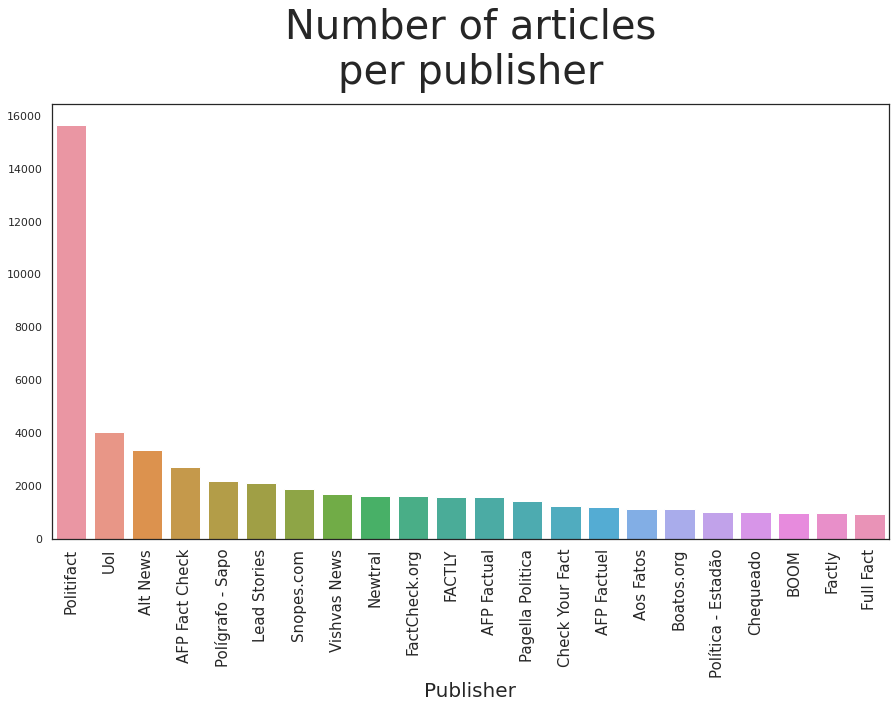

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90, fontsize=15)
df_agree['publisherNameLatinAlphabet'] = df_agree['publisherName'].apply(lambda row: 'Vishvas News' if row == 'विश्वास न्यूज़ फैक्ट चेक' else row)
g = sns.countplot(data=df_agree, x='publisherNameLatinAlphabet', order = df_agree['publisherNameLatinAlphabet'].value_counts().index[:22])
g.set_xlabel('Publisher', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper publisher', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


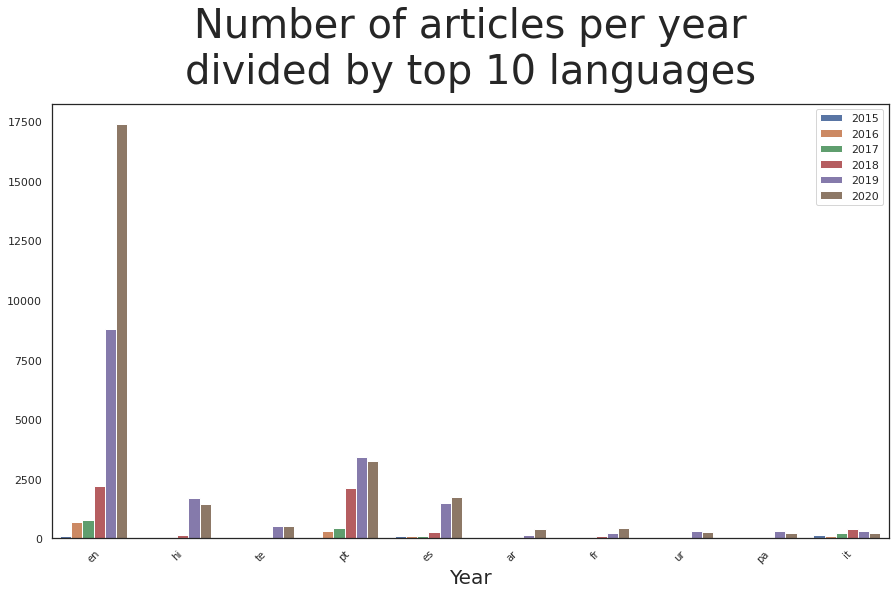

In [ ]:
df_reviewDate = df_agree[(df_agree['reviewDate'].isna() == False) & (df_agree['reviewDate'] != 'None')]
df_reviewDate['reviewDate'] = pd.to_datetime(df_reviewDate['reviewDate'], utc=True)
df_reviewDate['reviewYear'] = df_reviewDate['reviewDate'].dt.year
df_reviewDate = df_reviewDate[df_reviewDate['reviewYear'].isna() == False]
df_reviewDate['reviewYear'] = df_reviewDate['reviewYear'].apply(lambda row: int(row))
languages_to_keep = ['en', 'pt', 'es', 'hi', 'it', 'te', 'fr', 'ar', 'ur', 'pa']

plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df_reviewDate[(df_reviewDate['languageCode'].isin(languages_to_keep)) & (df_reviewDate['reviewYear'] >= 2015)], x='languageCode', hue='reviewYear')#, order = df_reviewDate['reviewYear'].value_counts().index[:5].sort_values(ascending=False))
g.set_xlabel('Year', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles per year\ndivided by top 10 languages', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Claims word count (less than 100 words)')

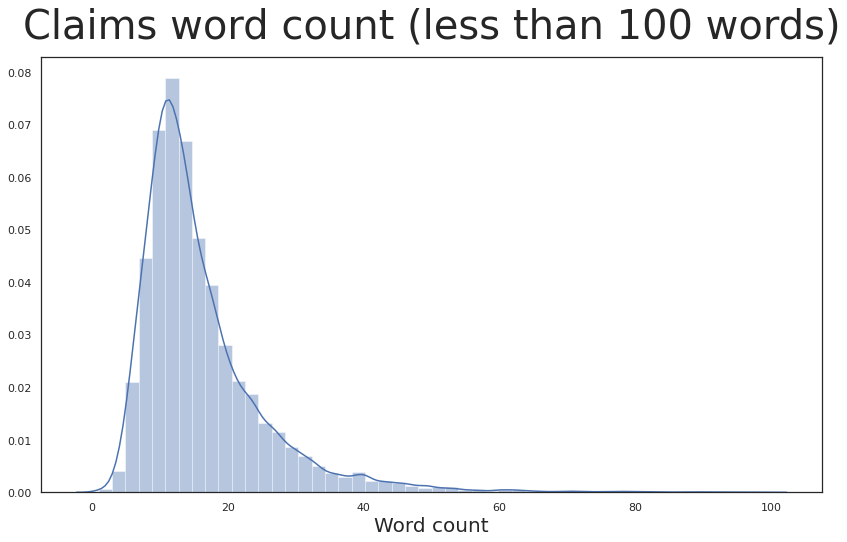

In [ ]:
df_agree['claimNumWords'] = df_agree['claim'].astype(str).apply(lambda row: len(row.split(' ')))
plt.figure(figsize = (14,8))
g = sns.distplot(df_agree[df_agree['claimNumWords'] < 100]['claimNumWords'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Claims word count (less than 100 words)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Articles word count\n(less than 2000 words)')

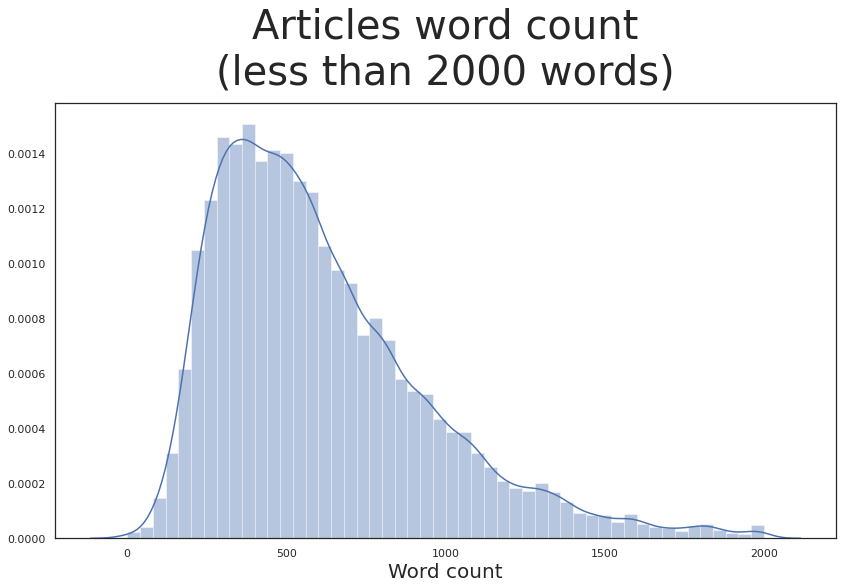

In [ ]:
df_agree['articleNumWords'] = df_agree['articleBody'].astype(str).apply(lambda row: len(row.split(' ')))
plt.figure(figsize = (14,8))
g = sns.distplot(df_agree[df_agree['articleNumWords'] < 2000]['articleNumWords'], bins=50)
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Articles word count\n(less than 2000 words)', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


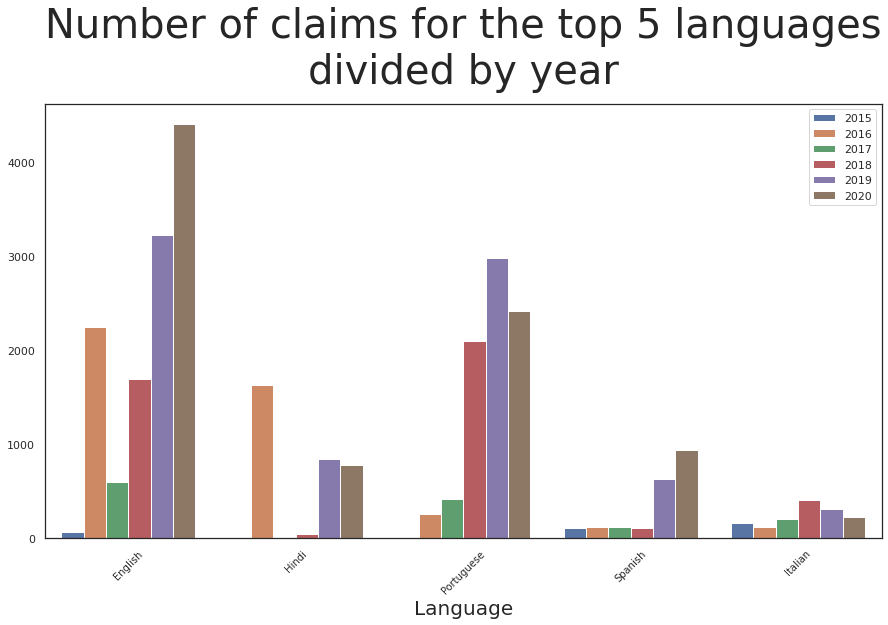

In [ ]:
df_claimDate = df_agree[(df_agree['claimDate'].isna() == False) & (df_agree['claimDate'] != 'None')]
df_claimDate['claimDate'] = pd.to_datetime(df_claimDate['claimDate'], utc=True)
df_claimDate['claimYear'] = df_claimDate['claimDate'].dt.year
df_claimDate = df_claimDate[df_claimDate['claimYear'].isna() == False]
df_claimDate['claimYear'] = df_claimDate['claimYear'].apply(lambda row: int(row))
languages_to_show = ['English', 'Hindi', 'Portuguese', 'Spanish', 'Italian']

plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df_claimDate[(df_claimDate['language'].isin(languages_to_show)) & (df_claimDate['claimYear'] >= 2015) & (df_claimDate['claimYear'] <= 2020)], x='language', hue='claimYear')#, order = df_claimDate['claimYear'].value_counts().index[:5].sort_values(ascending=False))
g.set_xlabel('Language', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims for the top 5 languages\ndivided by year', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

No handles with labels found to put in legend.


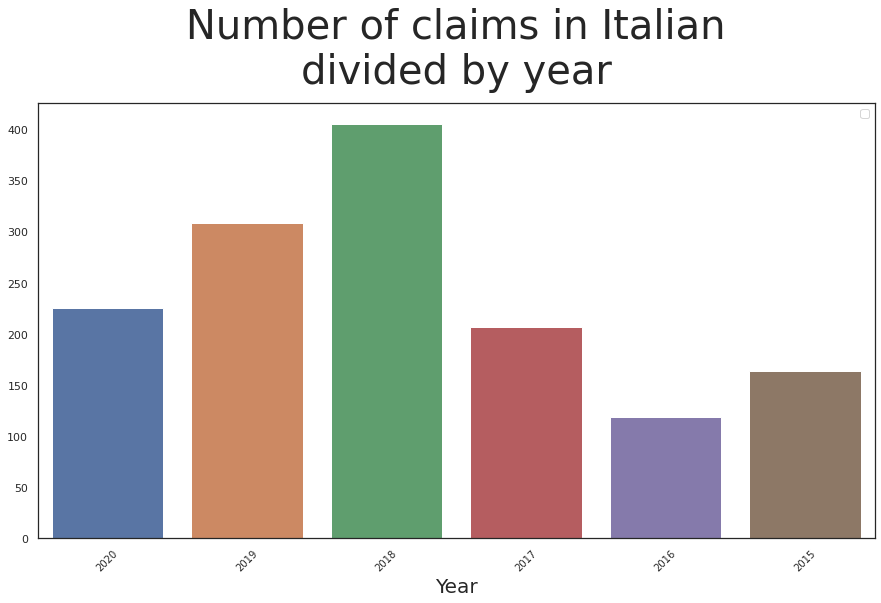

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_italy_publisher = df_claimDate[(df_claimDate['languageCode'] == 'it') & (df_claimDate['claimYear'].isin([2020,2019,2018,2017,2016,2015]))]
g = sns.countplot(data=df_italy_publisher, x='claimYear', order = df_italy_publisher['claimYear'].value_counts().index.sort_values(ascending=False))
g.set_xlabel('Year', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims in Italian\ndivided by year', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

In [ ]:
len(df_agree)

52877

In [ ]:
import collections
import nltk
nltk.download('stopwords')
en_stops = set(nltk.corpus.stopwords.words('english'))
pt_stops = set(nltk.corpus.stopwords.words('portuguese'))
it_stops = set(nltk.corpus.stopwords.words('italian'))
fr_stops = set(nltk.corpus.stopwords.words('french'))
es_stops = set(nltk.corpus.stopwords.words('spanish'))
de_stops = set(nltk.corpus.stopwords.words('german'))
tot_stops = en_stops.union(pt_stops).union(it_stops).union(fr_stops).union(es_stops).union(de_stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Collect all claims together
all_claims_en = " ".join(df_agree[df_agree['languageCode'] == 'en']['claim'].tolist())
all_claims_pt = " ".join(df_agree[df_agree['languageCode'] == 'pt']['claim'].tolist())
all_claims_it = " ".join(df_agree[df_agree['languageCode'] == 'it']['claim'].tolist())
all_claims_fr = " ".join(df_agree[df_agree['languageCode'] == 'fr']['claim'].tolist())
all_claims_es = " ".join(df_agree[df_agree['languageCode'] == 'es']['claim'].tolist())
all_claims_tot = " ".join(df_agree[df_agree['languageCode'].isin(['en','pt','it','fr','es'])]['claim'].tolist())

pattern = r"\W"

#Count words in all_claims that are not stopwords
def countwords(all_claims, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_claims.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_en = countwords(all_claims_en, en_stops)
wordcount_pt = countwords(all_claims_pt, pt_stops)
wordcount_it = countwords(all_claims_it, it_stops)
wordcount_fr = countwords(all_claims_fr, fr_stops)
wordcount_es = countwords(all_claims_es, es_stops)
wordcount_tot = countwords(all_claims_tot, tot_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_en = sorted(wordcount_en.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_pt = sorted(wordcount_pt.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_it = sorted(wordcount_it.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_fr = sorted(wordcount_fr.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_es = sorted(wordcount_es.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_tot = sorted(wordcount_tot.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc, language):
  print("Most common words in {0}:\n".format(language))
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered_en = filter_mc(mc_en, 'English')
mc_filtered_pt = filter_mc(mc_pt, 'Portuguese')
mc_filtered_it = filter_mc(mc_it, 'Italian')
mc_filtered_fr = filter_mc(mc_fr, 'French')
mc_filtered_es = filter_mc(mc_es, 'Spanish')
mc_filtered_tot = filter_mc(mc_tot, 'Total')

How many top words do you wish to print?30
The most common 30 words are:

Most common words in English:

trump : 2611
says : 2580
shows : 2434
coronavirus : 2407
people : 2259
president : 2162
covid19 : 1820
us : 1684
video : 1503
said : 1499
donald : 1404
photo : 1369
new : 1207
state : 926
claims : 905
biden : 885
police : 840
joe : 836
years : 792
one : 788
million : 775
states : 773
would : 768
obama : 739
bill : 706
house : 697
man : 677
health : 657
2020 : 628
year : 625


Most common words in Portuguese:

brasil : 744
bolsonaro : 705
redes : 699
sociais : 689
r : 500
governo : 480
publicação : 474
anos : 448
mil : 419
presidente : 400
milhões : 386
lula : 382
ser : 375
pessoas : 334
vai : 292
contra : 287
hoje : 285
covid19 : 277
paulo : 274
dia : 272
todos : 256
pt : 254
rio : 249
sobre : 233
ano : 229
coronavírus : 225
país : 224
vídeo : 223
agora : 222
mundo : 221


Most common words in Italian:

min : 401
euro : 195
mila : 192
governo : 182
miliardi : 179
italia : 178
oggi :

In [ ]:
names = list(mc_filtered_en.keys())
values = list(mc_filtered_en.values())
collect_most_common_words(names, values, 'agreement_en')

In [ ]:
names = list(mc_filtered_pt.keys())
values = list(mc_filtered_pt.values())
collect_most_common_words(names, values, 'agreement_pt')

In [ ]:
names = list(mc_filtered_it.keys())
values = list(mc_filtered_it.values())
collect_most_common_words(names, values, 'agreement_it')

In [ ]:
names = list(mc_filtered_fr.keys())
values = list(mc_filtered_fr.values())
collect_most_common_words(names, values, 'agreement_fr')

In [ ]:
names = list(mc_filtered_es.keys())
names[1] = 'anos'
names[5] = "espana"
names[10] = "pais"
names[21] = 'policia'
names[22] = 'ano'
names[25] = 'ultimos'
names[28] = 'sanchez'
names

['coronavirus',
 'anos',
 'covid19',
 'gobierno',
 'argentina',
 'espana',
 'millones',
 'muestra',
 'foto',
 'vídeo',
 'pais',
 'dos',
 'mil',
 'hoy',
 'madrid',
 'personas',
 'video',
 'imagen',
 'méxico',
 'cada',
 'nuevo',
 'policia',
 'ano',
 'euros',
 'dice',
 'ultimos',
 'menos',
 'hace',
 'sanchez',
 'si']

In [ ]:
collect_most_common_words(names, values, 'agreement_es')

In [ ]:
names = list(mc_filtered_tot.keys())
values = list(mc_filtered_tot.values())
collect_most_common_words(names, values, 'agreement_tot')

## Bias detector

### Wikipedia

In [ ]:
!wget http://bit.ly/bias-corpus
!unzip bias-corpus

--2020-11-04 23:42:32--  http://bit.ly/bias-corpus
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://nlp.stanford.edu/projects/bias/bias_data.zip [following]
--2020-11-04 23:42:33--  http://nlp.stanford.edu/projects/bias/bias_data.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/projects/bias/bias_data.zip [following]
--2020-11-04 23:42:33--  https://nlp.stanford.edu/projects/bias/bias_data.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109612243 (105M) [application/zip]
Saving to: ‘bias-corpus’

bias-corpus         100%[===================>] 104.53M   498KB/s    i

In [ ]:
df = pd.read_csv('bias_data/WNC/biased.full', sep='\t', error_bad_lines=False, names=['id', 'src_tok', 'tgt_tok', 'src_raw', 'tgt_raw', 'src_POS_tags', 'tgt_parse_tags'])

In [ ]:
df = df.drop(df.columns.difference(['src_raw', 'tgt_raw']), axis=1)
df = df.rename(columns={'src_raw':'unedited', 'tgt_raw': 'edited'})

In [ ]:
df['length'] = df['unedited'].apply(len)
df['wordcount'] = df['unedited'].apply(lambda row: len(row.split(' ')))

In [ ]:
df['length'].describe()

count    181474.000000
mean        179.390034
std         107.089183
min          12.000000
25%         114.000000
50%         162.000000
75%         224.000000
max       22189.000000
Name: length, dtype: float64

In [ ]:
df['wordcount'].describe()

count    181474.000000
mean         29.143255
std          17.757715
min           2.000000
25%          19.000000
50%          26.000000
75%          36.000000
max        3953.000000
Name: wordcount, dtype: float64

In [ ]:
df[df['wordcount'] < 3953]['wordcount'].describe()

count    181473.000000
mean         29.121632
std          15.182049
min           2.000000
25%          19.000000
50%          26.000000
75%          36.000000
max         292.000000
Name: wordcount, dtype: float64

### News paper dataset: first (all the news + r/conservative)

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1fcPuwAAkKegtpxWjuDYf5H3QvtsTd4_A/view?usp=sharing', 'news_bias_first.csv')

In [ ]:
df_news = pd.read_csv('news_bias_first.csv')

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167845 entries, 0 to 167844
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   article    167845 non-null  object
 1   url        167845 non-null  object
 2   publisher  167845 non-null  object
 3   rating     167845 non-null  int64 
 4   biased     167845 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 6.4+ MB


In [ ]:
df_news['rating'] = df_news['rating'].apply(lambda row: -1 if row < 0.0 else 0 if row==0.0 else 1)

In [ ]:
df_news.groupby(by='rating').count()

,article,url,publisher
rating,,,
-1,57518,57518,57518
0,56615,56615,56615
1,53712,53712,53712


In [ ]:
df_news['biased'] = df_news['rating'].apply(lambda row: 0 if row == 0.0 else 1) 

In [ ]:
df_news[df_news['biased'] == 0]['publisher'].unique()

array(['Reuters', 'apnews.com'], dtype=object)

In [ ]:
df_news['length'] = df_news['article'].apply(len)
df_news['wordcount'] = df_news['article'].apply(lambda row: len(row.split(' ')))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Biased articles length')

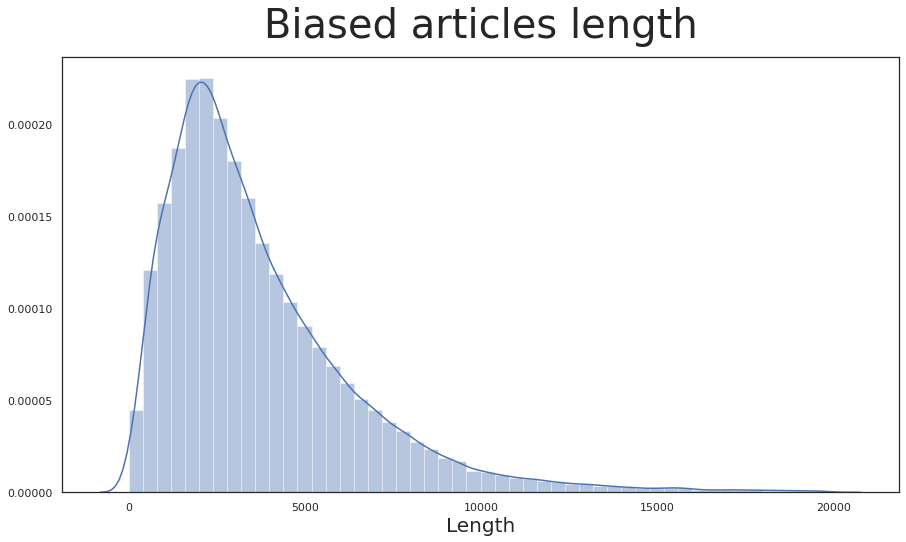

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_news[(df_news['biased'] == 1) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Biased articles length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unbiased articles length')

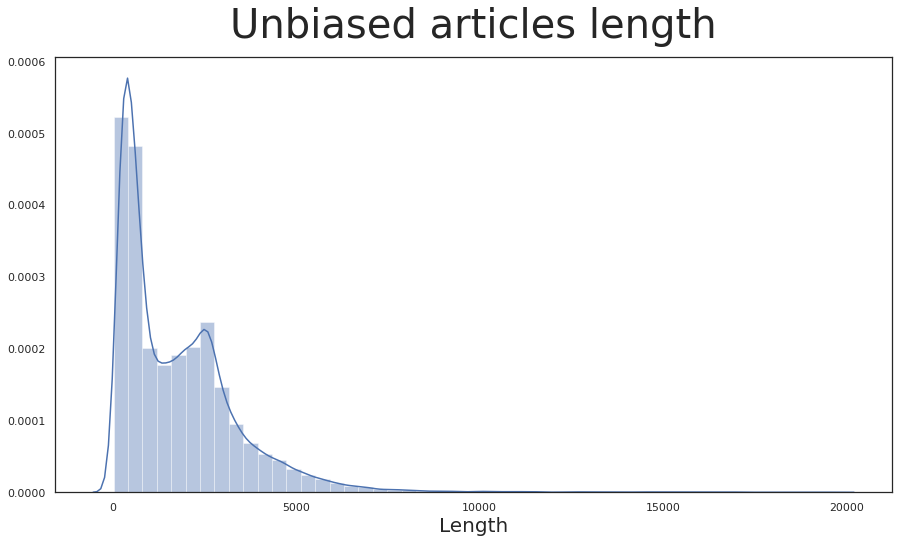

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_news[(df_news['biased'] == 0) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Unbiased articles length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Biased articles word count')

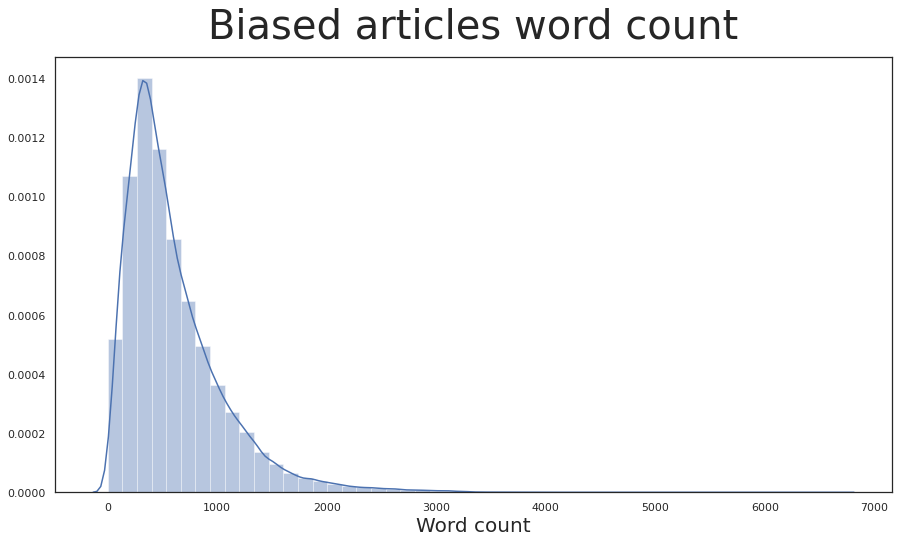

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['biased'] == 1) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Biased articles word count', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unbiased articles word count')

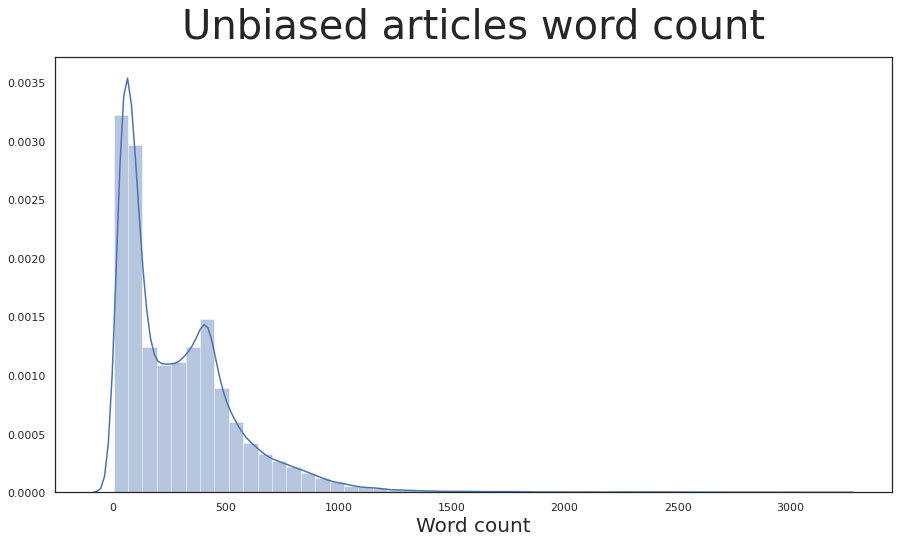

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['biased'] == 0) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Unbiased articles word count', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_news[df_news['biased'] == 0]['article'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 155833
reuters : 69898
us : 50887
percent : 48631
million : 41871
reporting : 39912
would : 39660
year : 38606
new : 37587
editing : 36139
company : 35596
also : 31030
last : 30305
billion : 29437
two : 24926
first : 23789
one : 23053
could : 22275
government : 22126
market : 20706
bank : 20054
since : 19344
may : 18610
people : 17959
years : 17957
president : 17929
told : 17637
source : 17458
china : 17004
states : 16887




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'unbiased')

In [ ]:
#Collect all articles together
all_articles = " ".join(df_news[df_news['biased'] == 1]['article'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 315249
trump : 208944
people : 171051
one : 166750
would : 156981
new : 153055
president : 146639
us : 130506
like : 129074
also : 128037
time : 99812
even : 84791
get : 84789
could : 84135
first : 83987
two : 78601
news : 77320
last : 75802
house : 74201
years : 74077
told : 71813
mr : 68910
many : 68547
state : 67631
going : 66217
dont : 65392
know : 64312
year : 63999
states : 63632
think : 63547




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'biased')

### News paper dataset: second (unbiased all the news + r/conservative + r/liberal)

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1jSCMH2FltI19PNowoEgMKumrt42UdGXO/view?usp=sharing', 'third_bias_dataset_reddit_reuters.csv')
df_news = pd.read_csv('third_bias_dataset_reddit_reuters.csv')

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144347 entries, 0 to 144346
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lean_right  144347 non-null  int64 
 1   text        143379 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df_news.groupby(by='lean_right').count()

,text
lean_right,
-1,36648
0,54032
1,52699


In [ ]:
df_news['biased'] = df_news['lean_right'].apply(lambda row: 1 if row != 0 else 0)

In [ ]:
df_news['length'] = df_news['text'].astype(str).apply(len)
df_news['wordcount'] = df_news['text'].astype(str).apply(lambda row: len(row.split(' ')))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Biased articles length')

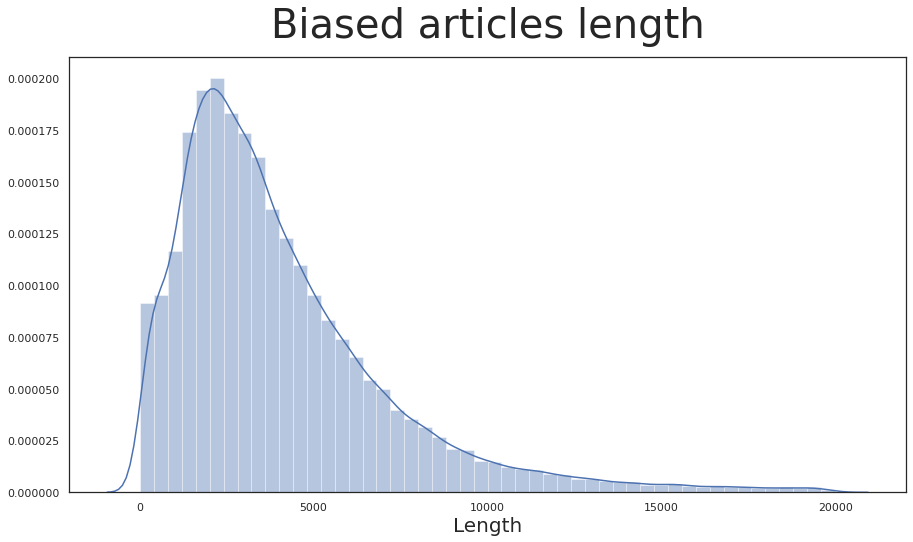

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_news[(df_news['biased'] == 1) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Biased articles length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unbiased articles length')

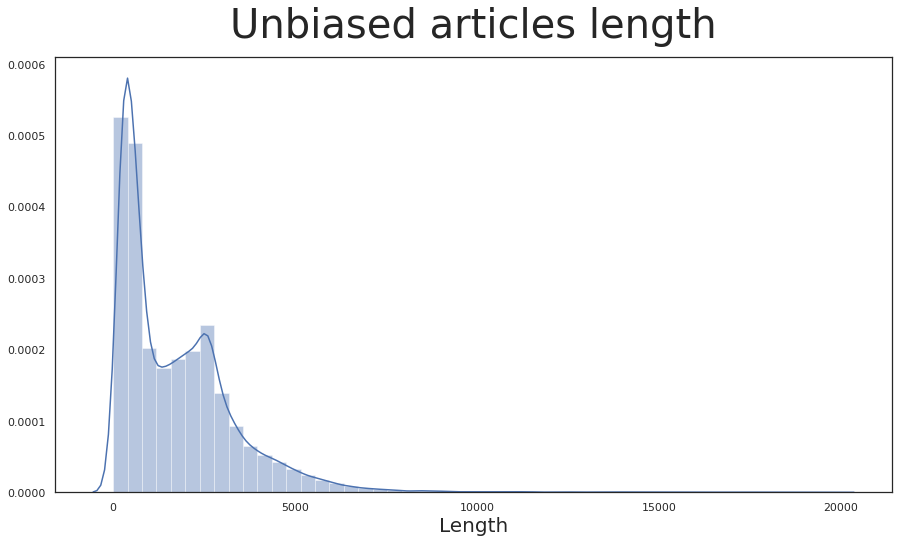

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Articles length')
g = sns.distplot(df_news[(df_news['biased'] == 0) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Unbiased articles length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Biased articles word count')

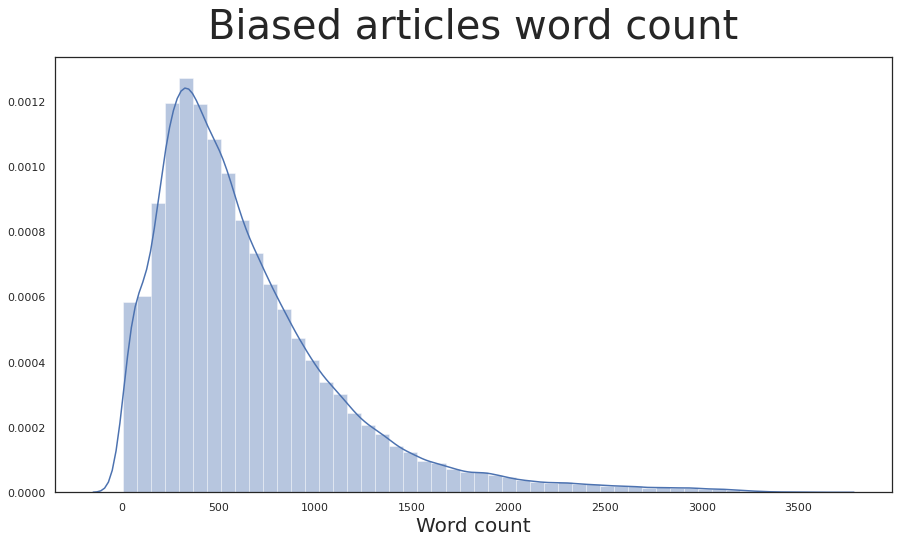

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['biased'] == 1) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Biased articles word count', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Unbiased articles word count')

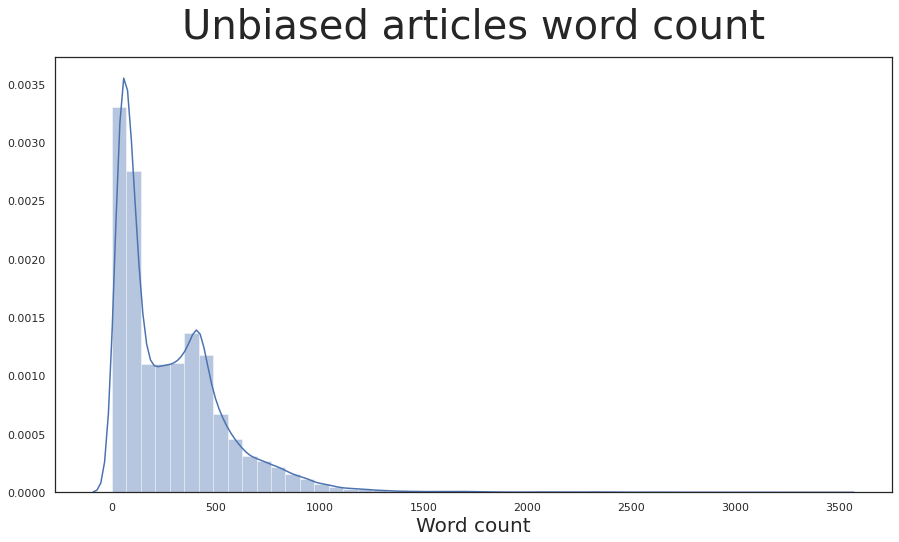

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['biased'] == 0) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Unbiased articles word count', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Right-wing articles word count')

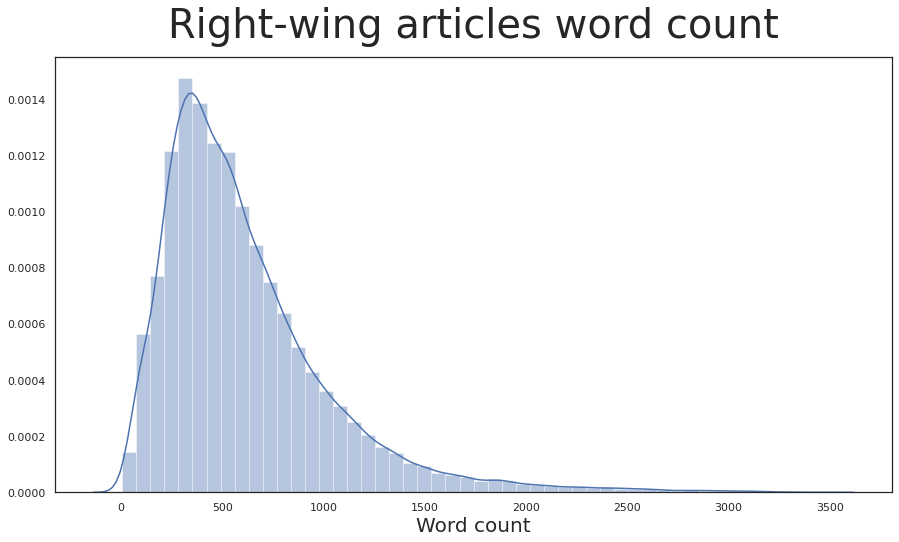

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['lean_right'] == 1) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Right-wing articles word count', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Left-wing articles word count')

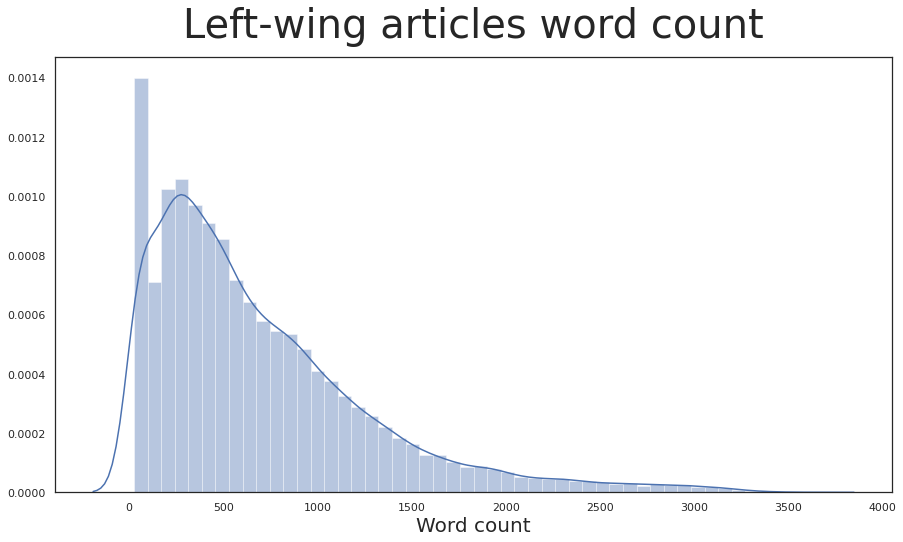

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['lean_right'] == -1) & (df_news['length'] < 20000)]['wordcount'])
g.set_xlabel('Word count', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Left-wing articles word count', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles_u = " ".join(df_news[df_news['biased'] == 0]['text'].astype(str).tolist())
all_articles_b = " ".join(df_news[df_news['biased'] == 1]['text'].astype(str).tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_u = countwords(all_articles_u, en_stops)
wordcount_b = countwords(all_articles_b, en_stops)

#Decide how many words to print
#to_print = int(input("How many top words do you wish to print?"))
to_print = 30
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_u = sorted(wordcount_u.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_b = sorted(wordcount_b.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

print("Unbiased")
mc_filtered_u = filter_mc(mc_u)

print("\n")
print("Biased")
mc_filtered_b = filter_mc(mc_b)

The most common 30 words are:

Unbiased
Most common words:

said : 146857
reuters : 66928
percent : 48436
us : 47908
million : 39887
reporting : 37955
would : 37122
year : 36670
new : 35249
editing : 34446
company : 33906
last : 28941
also : 28825
billion : 27980
two : 23724
first : 22617
one : 21897
government : 21009
could : 20966
market : 20035
bank : 18746
since : 18382
may : 17680
years : 17138
people : 16849
told : 16772
source : 16727
president : 16226
china : 16185
states : 15812




Biased
Most common words:

said : 238977
trump : 227318
people : 167012
would : 163714
president : 157415
one : 143500
new : 130625
us : 129529
also : 105527
like : 95676
sanders : 94021
state : 93854
democratic : 83723
campaign : 82955
even : 81859
time : 80824
house : 80024
states : 79628
democrats : 79556
biden : 77909
could : 72240
news : 71685
get : 69438
first : 68280
many : 67262
white : 66618
political : 64598
american : 62718
years : 62530
election : 62077




In [ ]:
names = list(mc_filtered_u.keys())
values = list(mc_filtered_u.values())
collect_most_common_words(names, values, 'unbiased')

names = list(mc_filtered_b.keys())
values = list(mc_filtered_b.values())
collect_most_common_words(names, values, 'biased')

In [ ]:
#Collect all articles together
all_articles_l = " ".join(df_news[df_news['lean_right'] == -1]['text'].astype(str).tolist())
all_articles_r = " ".join(df_news[df_news['lean_right'] == 1]['text'].astype(str).tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_l = countwords(all_articles_l, en_stops)
wordcount_r = countwords(all_articles_r, en_stops)

#Decide how many words to print
#to_print = int(input("How many top words do you wish to print?"))
to_print = 30
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_l = sorted(wordcount_l.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_r = sorted(wordcount_r.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

print("Unbiased")
mc_filtered_l = filter_mc(mc_l)

print("\n")
print("Biased")
mc_filtered_r = filter_mc(mc_r)

The most common 30 words are:

Unbiased
Most common words:

said : 103634
trump : 83635
would : 83332
sanders : 80444
people : 77760
one : 67422
us : 62601
new : 61647
president : 55947
democratic : 53098
state : 52343
campaign : 50671
clinton : 49690
also : 49406
like : 48949
states : 41811
even : 39058
time : 38631
percent : 38488
party : 38066
could : 36525
political : 36489
democrats : 35965
election : 35614
house : 34951
many : 34334
first : 34004
voters : 33488
years : 32858
republican : 32435




Biased
Most common words:

trump : 143683
said : 135343
president : 101468
people : 89252
would : 80382
one : 76078
new : 68978
us : 66928
biden : 59517
also : 56121
news : 50648
2020 : 47695
like : 46727
police : 45310
house : 45073
democrats : 43591
even : 42801
time : 42193
state : 41511
white : 38454
get : 38374
states : 37817
could : 35715
media : 34928
first : 34276
coronavirus : 34048
told : 33859
american : 33708
two : 33136
many : 32928




In [ ]:
names = list(mc_filtered_l.keys())
values = list(mc_filtered_l.values())
collect_most_common_words(names, values, 'left')

names = list(mc_filtered_r.keys())
values = list(mc_filtered_r.values())
collect_most_common_words(names, values, 'right')

## Ideology detector

### Manually labeled dataset

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1kb_bfCWGLlaX0hZHIUMmRsBSCdXF40jW/view?usp=sharing', 'bias_news.csv')
df = pd.read_csv('bias_news.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        2093 non-null   object
 1   lean_left  2093 non-null   int64 
 2   text       1973 non-null   object
dtypes: int64(1), object(2)
memory usage: 49.2+ KB


In [ ]:
df = df[df['text'].isna() == False]

In [ ]:
len(df)

1973

In [ ]:
df['length'] = df['text'].apply(len)
df['wordcount'] = df['text'].apply(lambda row: len(row.split(' ')))

In [ ]:
df['length'].describe()

count     1973.000000
mean      2697.761784
std       2518.663901
min          4.000000
25%        433.000000
50%       2284.000000
75%       4366.000000
max      14480.000000
Name: length, dtype: float64

In [ ]:
df['wordcount'].describe()

count    1973.000000
mean      429.845413
std       399.985855
min         1.000000
25%        70.000000
50%       365.000000
75%       699.000000
max      2255.000000
Name: wordcount, dtype: float64

In [ ]:
df[df['lean_left'] == 1]['wordcount'].describe()

count    1165.000000
mean      438.873820
std       412.234399
min         1.000000
25%        80.000000
50%       354.000000
75%       715.000000
max      2255.000000
Name: wordcount, dtype: float64

In [ ]:
df['wordcount'].describe()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Left leaning articles length')

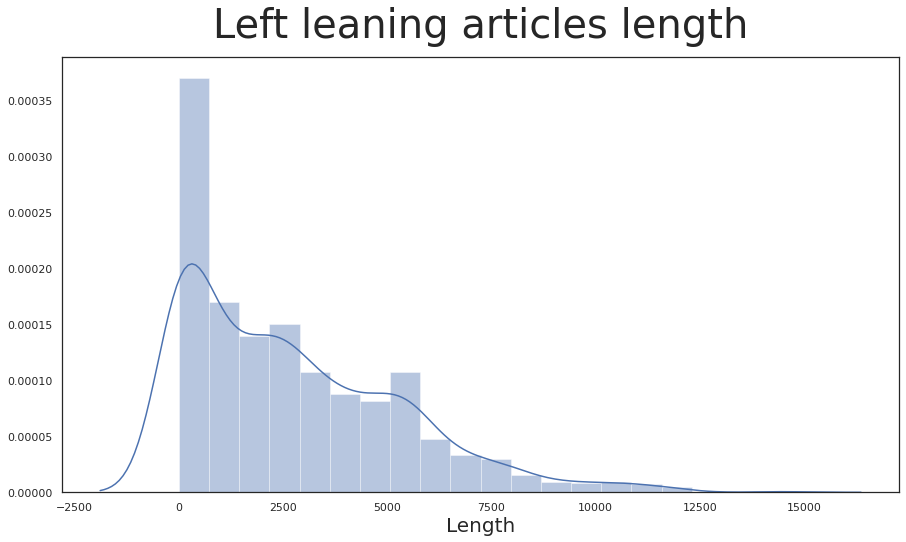

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df[(df['lean_left'] == 1) & (df['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Left leaning articles length', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df[df['lean_left'] == 0]['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 2132
obama : 1366
house : 1157
president : 1096
would : 1087
republicans : 959
government : 815
people : 764
senate : 733
one : 703
new : 696
us : 662
republican : 648
democrats : 640
party : 587
law : 554
state : 537
also : 536
obamacare : 533
health : 512
white : 503
congress : 503
political : 483
media : 471
time : 460
administration : 451
like : 445
care : 442
bill : 438
americans : 432




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())
collect_most_common_words(names, values, 'left_leaning')

In [ ]:
save_file_to_drive('frequent_words_left_leaning.txt', 'frequent_words_left_leaning.txt')

File ID: 1JsTDixpVUGLW6gOVMuKcgKt74dR7tVFE


{'id': '1JsTDixpVUGLW6gOVMuKcgKt74dR7tVFE'}

In [ ]:
#Collect all articles together
all_articles = " ".join(df[df['lean_left'] == 1]['text'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 2630
obama : 1771
would : 1724
republicans : 1515
house : 1445
president : 1407
people : 1212
new : 1178
one : 1119
republican : 1079
senate : 1065
state : 951
law : 948
government : 887
us : 864
health : 862
gun : 853
party : 842
democrats : 842
states : 819
also : 800
bill : 750
could : 725
like : 719
time : 693
white : 678
care : 661
even : 655
many : 650
get : 643




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'right_leaning')

In [ ]:
save_file_to_drive('frequent_words_right_leaning.txt', 'frequent_words_right_leaning.txt')

File ID: 1HOV0WHmQUcT7zL2XnFytYkRNAjAH68QC


{'id': '1HOV0WHmQUcT7zL2XnFytYkRNAjAH68QC'}

### Newspaper dataset: first (all the news + r/conservative)

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1fcPuwAAkKegtpxWjuDYf5H3QvtsTd4_A/view?usp=sharing', 'news_bias_first.csv')
df_news = pd.read_csv('news_bias_first.csv')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167845 entries, 0 to 167844
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   article    167845 non-null  object 
 1   url        167845 non-null  object 
 2   publisher  167845 non-null  object 
 3   rating     167845 non-null  float64
dtypes: float64(1), object(3)
memory usage: 5.1+ MB


In [ ]:
df_news['rating'] = df_news['rating'].apply(lambda row: -1 if row < 0.0 else 0 if row==0.0 else 1)

In [ ]:
df_news = df_news[df_news['rating'] != 0]
df_news['is_left'] = df_news['rating'].apply(lambda row: 1 if row == -1 else 0)

In [ ]:
df_news['length'] = df_news['article'].apply(len)
df_news['wordcount'] = df_news['article'].apply(lambda row: len(row.split(' ')))

In [ ]:
df_news['length'].describe()

count    111230.000000
mean       3892.596952
std        3799.902022
min           1.000000
25%        1818.000000
50%        3012.000000
75%        4934.000000
max      140711.000000
Name: length, dtype: float64

In [ ]:
df_news[df_news['is_left'] == 0]['wordcount'].describe()

count    53712.000000
mean       645.046098
std        588.514739
min          7.000000
25%        339.000000
50%        520.000000
75%        788.000000
max      17246.000000
Name: wordcount, dtype: float64

In [ ]:
df_news[df_news['is_left'] == 1]['wordcount'].describe()

count    57518.000000
mean       627.582913
std        678.806245
min          1.000000
25%        256.000000
50%        451.000000
75%        820.000000
max      25263.000000
Name: wordcount, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Left leaning articles length')

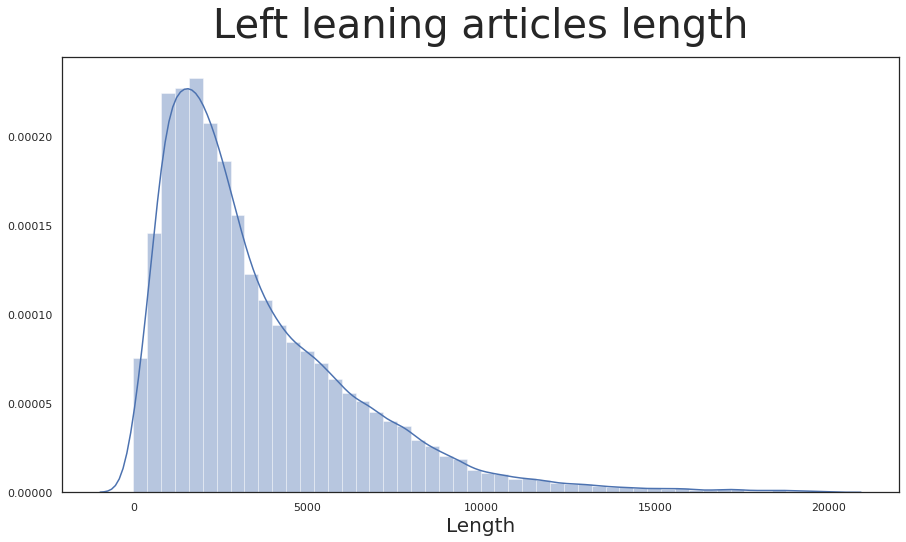

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['is_left'] == 1) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Left leaning articles length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Right leaning articles length')

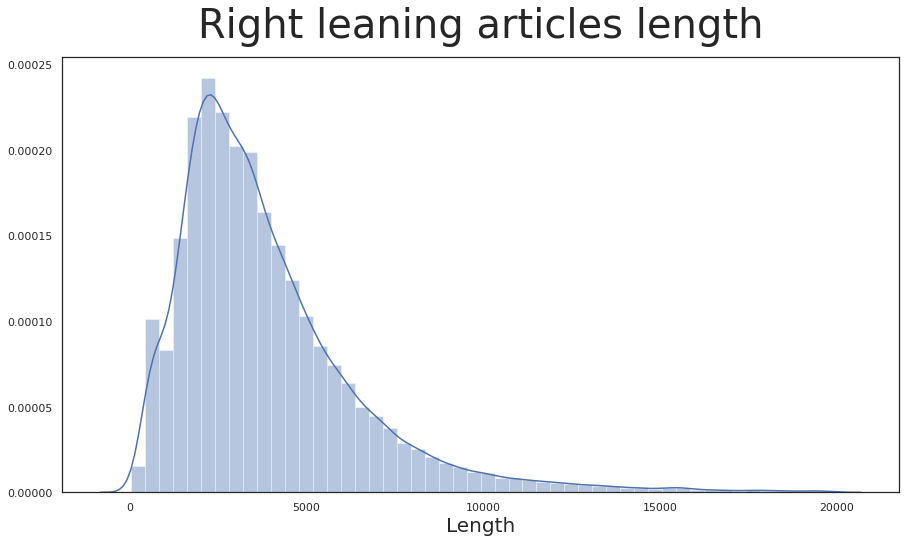

In [ ]:
plt.figure(figsize = (15,8))
g = sns.distplot(df_news[(df_news['is_left'] == 0) & (df_news['length'] < 20000)]['length'])
g.set_xlabel('Length', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Right leaning articles length', fontsize = 40, pad=20)

In [ ]:
#Collect all articles together
all_articles = " ".join(df_news[df_news['is_left'] == 0]['article'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

trump : 144342
said : 140719
president : 103962
people : 91552
would : 81938
one : 78473
new : 70466
us : 69589
also : 58135
biden : 57286
news : 53560
like : 48739
2020 : 47146
police : 47056
house : 45624
time : 43914
democrats : 43799
even : 43399
state : 42476
get : 40210
states : 37926
white : 37893
could : 36750
media : 36017
told : 35964
first : 35939
two : 35111
going : 34799
last : 34303
american : 34192




In [ ]:
#Collect all articles together
all_articles = " ".join(df_news[df_news['is_left'] == 1]['article'].tolist())

pattern = r"\W"

#Count words in all_articles that are not stopwords
def countwords(all_articles, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_articles.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount = countwords(all_articles, en_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc):
  print("Most common words:\n")
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered = filter_mc(mc)

How many top words do you wish to print?30
The most common 30 words are:

Most common words:

said : 174530
one : 88277
new : 82589
like : 80335
people : 79499
would : 75043
also : 69902
trump : 64602
us : 60917
time : 55898
mr : 55620
first : 48048
could : 47385
get : 44579
two : 43490
years : 42900
president : 42677
last : 41499
even : 41392
year : 41228
told : 35849
make : 35053
many : 34969
dont : 33749
back : 32903
think : 32794
way : 32367
going : 31418
still : 30646
much : 30646




In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'right_leaning')

In [ ]:
save_file_to_drive('frequent_words_right_leaning.txt', 'frequent_words_right_leaning.txt')

File ID: 1fHA2Mbiqk9kfqQjaIKspzdF5dytvpbMu


{'id': '1fHA2Mbiqk9kfqQjaIKspzdF5dytvpbMu'}

## Multilingual experiment

In [ ]:
upload_from_drive('https://drive.google.com/file/d/1Py8tLtaV5cMPoy6Nw8GO8LBdjNKjXCSg/view?usp=sharing', 'reddit_multilingual_clean.csv')

In [ ]:
df = pd.read_csv('reddit_multilingual_clean.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33854 entries, 0 to 33853
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   domain           33851 non-null  object
 1   link_flair_text  15359 non-null  object
 2   selftext         5110 non-null   object
 3   subreddit        33854 non-null  object
 4   title            33854 non-null  object
 5   url              33854 non-null  object
 6   language         33854 non-null  object
 7   category         33854 non-null  object
dtypes: object(8)
memory usage: 2.1+ MB


Text(0.5, 1.0, 'Number of entries per category')

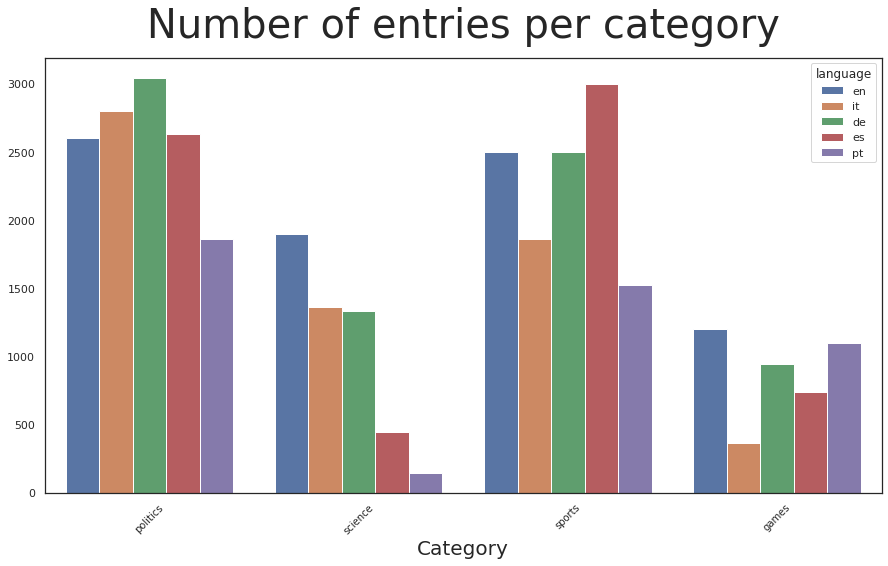

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='category', hue='language')
g.set_xlabel('Category', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of entries per category', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of entries per language')

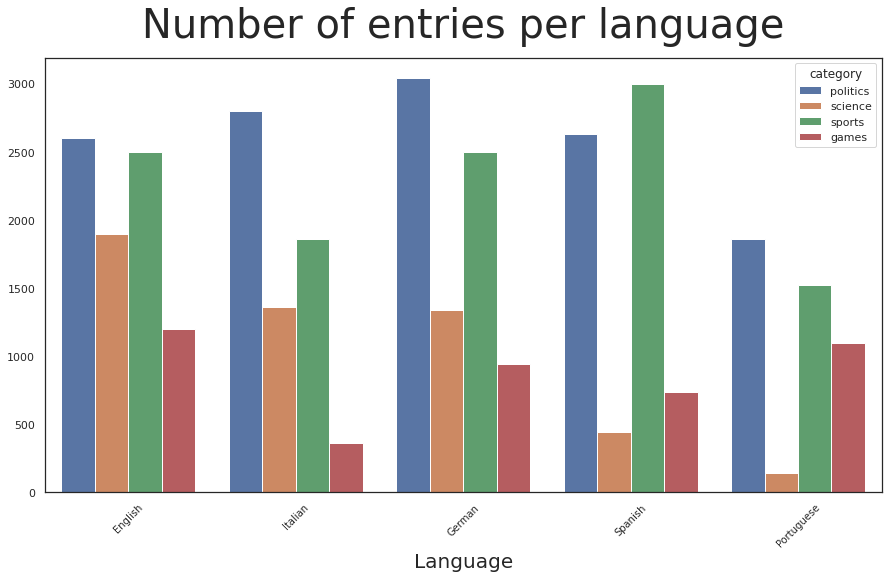

In [ ]:
lang = {'en': 'English', 'it': 'Italian', 'de': 'German', 'pt': 'Portuguese', 'es': 'Spanish'}
df['language'] = df['language'].apply(lambda row: lang[row])
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df, x='language', hue='category')
g.set_xlabel('Language', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of entries per language', fontsize = 40, pad=20)

In [ ]:
df.groupby(by='language').count()

,domain,link_flair_text,selftext,subreddit,title,url,category
language,,,,,,,
English,8200,3449,969,8200,8200,8200,8200
German,7819,5785,1617,7819,7819,7819,7819
Italian,6386,1512,560,6387,6387,6387,6387
Portuguese,4626,1637,800,4627,4627,4627,4627
Spanish,6820,2976,1164,6821,6821,6821,6821


In [ ]:
df.groupby(by='category').count()

,domain,link_flair_text,selftext,subreddit,title,url,language
category,,,,,,,
games,4343,1222,1772,4343,4343,4343,4343
politics,12940,8087,546,12940,12940,12940,12940
science,5186,2714,330,5188,5188,5188,5188
sports,11382,3336,2462,11383,11383,11383,11383


In [ ]:
df.groupby(by=['language','category']).count()

domain  link_flair_text  selftext  subreddit  title   url
language   category                                                           
English    games       1200                0       420       1200   1200  1200
           politics    2600              747        56       2600   2600  2600
           science     1900             1716        17       1900   1900  1900
           sports      2500              986       476       2500   2500  2500
German     games        942              356       321        942    942   942
           politics    3041             3041       284       3041   3041  3041
           science     1336              809       101       1336   1336  1336
           sports      2500             1579       911       2500   2500  2500
Italian    games        362               68       146        362    362   362
           politics    2800             1409       136       2800   2800  2800
           science     1363               35        88       1364   1364  1364
           sports      1861                0       190       1861   1861  1861
Portuguese games       1100              569       359       1100   1100  1100
           politics    1864              255        70       1864   1864  1864
           science      141              105        46        141    141   141
           sports      1521              708       325       1522   1522  1522
Spanish    games        739              229       526        739    739   739
           politics    2635             2635         0       2635   2635  2635
           science      446               49        78        447    447   447
           sports      3000               63       560       3000   3000  3000

In [ ]:
#Collect all articles together
for language in ['English', 'Italian', 'German', 'Spanish', 'Portuguese']:
  for category in ['politics', 'games', 'sports', 'science']:
    all_articles = " ".join(df[(df['language'] == language) & (df['category'] == category)]['title'].tolist())

    pattern = r"\W"

    #Count words in all_articles that are not stopwords
    def countwords(all_articles, stopwords):
      wordcount = collections.defaultdict(int)
      for word in all_articles.lower().split():
          word = re.sub(pattern, '', word)
          if word not in stopwords:
              wordcount[word] += 1
      return wordcount

    wordcount = countwords(all_articles, tot_stops)

    #Decide how many words to print
    #to_print = int(input("How many top words do you wish to print?"))
    to_print = 10
    print("The most common {0} words are:\n".format(to_print))

    #Sorts the the values in decreasing order and prints the first "to_print".
    mc = sorted(wordcount.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

    #Creates a dictionary to make the plots later
    def filter_mc(mc):
      print("Most common words:\n")
      mc_filtered = {}
      for word, count in mc:
        if word != '':
          print(word, ":", count)
          mc_filtered[word] = count
      print("\n")
      return mc_filtered

    print("Language: ", language)
    print("Category: ", category)
    print("\n")
    mc_filtered = filter_mc(mc)

    names = list(mc_filtered.keys())
    values = list(mc_filtered.values())
    collect_most_common_words(names, values, language + '_' + category)

The most common 10 words are:

Language:  English
Category:  politics


Most common words:

trump : 856
biden : 519
us : 237
says : 183
election : 176
trumps : 167
debate : 167
vote : 155
joe : 150
new : 126


The most common 10 words are:

Language:  English
Category:  games


Most common words:

game : 219
games : 126
trailer : 85
2 : 58
new : 55
xbox : 54
free : 54
us : 50
pc : 49
2020 : 45


The most common 10 words are:

Language:  English
Category:  sports


Most common words:

league : 321
vs : 209
thread : 205
1 : 180
match : 172
goal : 125
10 : 123
round : 120
madrid : 118
real : 114


The most common 10 words are:

Language:  English
Category:  science


Most common words:

new : 270
covid19 : 244
study : 240
scientists : 137
people : 114
may : 97
researchers : 92
found : 88
could : 86
human : 80


The most common 10 words are:

Language:  Italian
Category:  politics


Most common words:

lavoro : 79
crisi : 58
renzi : 54
guerra : 50
stato : 50
grecia : 47
governo : 46
mondo 

In [ ]:
names = list(mc_filtered.keys())
values = list(mc_filtered.values())

collect_most_common_words(names, values, 'right_leaning')

## Multi-task experiment

In [ ]:
!wget https://github.com/Dragonet95/utils/raw/master/DebatesAgreement.zip
!unzip DebatesAgreement.zip

--2020-11-05 19:14:48--  https://github.com/Dragonet95/utils/raw/master/DebatesAgreement.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/LFavano/utils/raw/master/DebatesAgreement.zip [following]
--2020-11-05 19:14:48--  https://github.com/LFavano/utils/raw/master/DebatesAgreement.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LFavano/utils/master/DebatesAgreement.zip [following]
--2020-11-05 19:14:49--  https://raw.githubusercontent.com/LFavano/utils/master/DebatesAgreement.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting resp

In [ ]:
_COL_NAMES = ['id', 'label','category','topic','subtopic','sentence1','sentence2']
dataset_agreement = pd.read_csv("./debates_agreement.tsv", index_col=None, header=None, names=_COL_NAMES, sep='\t')

In [ ]:
dataset_agreement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29343 entries, 0 to 29342
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         29343 non-null  int64 
 1   label      29343 non-null  object
 2   category   29343 non-null  object
 3   topic      29343 non-null  object
 4   subtopic   29246 non-null  object
 5   sentence1  29343 non-null  object
 6   sentence2  29341 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [ ]:
dataset_agreement['sentence1'][:5]

0    $700b bailout helps avoid widespread bankruptc...
1    $700b bailout helps avoid widespread bankruptc...
2    $700b bailout helps avoid widespread bankruptc...
3    $700b bailout helps avoid widespread bankruptc...
4    $700b bailout is generally well designed to so...
Name: sentence1, dtype: object

In [ ]:
dataset_agreement['sentence2'][:5]

0    $700 bailout wrongly trusts culprits to solve ...
1    $700 billion bailout plan is too little too la...
2    $700b bailout would increase US deficit and in...
3    No assurances that a $700b bailout would work ...
4    $700 bailout wrongly trusts culprits to solve ...
Name: sentence2, dtype: object